# THREE BODIES

## Libraries

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from plotly.subplots import make_subplots
from sklearn.feature_selection import VarianceThreshold
#preprocessings encodings
from sklearn.preprocessing import OneHotEncoder
#preprocessings standard scaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
#basic models
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# model selection
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold , cross_val_score
import time
from sklearn.ensemble import VotingRegressor

from sklearn.neighbors import KNeighborsRegressor

#metrics
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score



# Task 1

### Data preparation

In [174]:
df = pd.read_csv(f'/content/X_train.csv')

In [175]:
df.head(10)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0.0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1.0
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2.0
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3.0
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4.0
5,0.195312,0.988650,0.002321,-0.116689,0.023888,-0.261282,0.848781,0.053344,-0.107057,-0.727368,-0.851102,0.063344,0.083169,5.0
6,0.234375,0.983627,0.003350,-0.140528,0.028797,-0.258985,0.844173,0.064279,-0.128901,-0.724642,-0.847523,0.076249,0.100105,6.0
7,0.273438,0.977668,0.004572,-0.164650,0.033779,-0.256258,0.838708,0.075363,-0.150988,-0.721410,-0.843279,0.089287,0.117209,7.0
8,0.312500,0.970760,0.005990,-0.189111,0.038851,-0.253095,0.832374,0.086628,-0.173366,-0.717665,-0.838363,0.102483,0.134515,8.0
9,0.351562,0.962888,0.007608,-0.213969,0.044027,-0.249488,0.825159,0.098105,-0.196083,-0.713401,-0.832767,0.115864,0.152056,9.0


In [176]:
print (df.dtypes)

t        float64
x_1      float64
y_1      float64
v_x_1    float64
v_y_1    float64
x_2      float64
y_2      float64
v_x_2    float64
v_y_2    float64
x_3      float64
y_3      float64
v_x_3    float64
v_y_3    float64
Id       float64
dtype: object


In [177]:
last_id=df['Id'].max()
print(last_id)
print(last_id/258)

250083.0
969.3139534883721


Checking the number of collisions:

In [178]:
def num_collisions(df, position):
      collision = 0

      for index, row in df.iterrows():
        if all(row[col] == 0 for col in position):
            collision += 1
      return collision

In [179]:
position = [
        'x_1', 'y_1', 'v_x_1', 'v_y_1',
        'x_2', 'y_2', 'v_x_2', 'v_y_2',
        'x_3', 'y_3', 'v_x_3', 'v_y_3'
    ]

In [180]:
print('The number of collisions of the training dataset is:', num_collisions(df, position))

The number of collisions of the training dataset is: 37256


In [181]:
description = df.describe()
description.T.style.background_gradient(cmap='viridis',low=0.2,high=0.1)

,count,mean,std,min,25%,50%,75%,max
t,250085.000000,4.167059,3.208981,0.000000,1.054690,3.984380,6.992190,10.000000
x_1,250085.000000,-0.253828,1.721760,-25.835512,-0.381638,0.000000,0.510069,13.437104
y_1,250085.000000,-0.082979,1.093265,-12.241786,-0.386519,0.000000,0.266748,16.131800
v_x_1,250085.000000,-0.181890,0.877178,-43.702484,-0.561496,-0.068450,0.134582,15.377104
v_y_1,250085.000000,-0.011107,0.805290,-23.109278,-0.225198,0.000442,0.257303,25.396761
x_2,250085.000000,0.030382,1.048685,-7.622794,-0.313193,0.000000,0.212000,15.506957
y_2,250085.000000,-0.050773,0.913283,-10.525691,-0.176842,0.000000,0.269415,16.766627
v_x_2,250085.000000,0.037476,0.934124,-22.851445,-0.295406,0.000000,0.388453,43.902044
v_y_2,250085.000000,-0.073180,0.974992,-20.208194,-0.490983,0.000000,0.336766,23.118346
x_3,250085.000000,0.223446,1.336226,-13.350578,-0.443525,0.000000,0.456086,15.194271


Checking and treating the nans:


In [182]:
def has_nans(df):
  return df.isna().sum().sum()>0

print(has_nans(df))

True


In [183]:
nan_trajectory = df['Id'].isna()
print(nan_trajectory)

0         False
1         False
2         False
3         False
4         False
          ...  
250080    False
250081    False
250082    False
250083    False
250084     True
Name: Id, Length: 250085, dtype: bool


In [184]:
print(df.tail(1))


               t       x_1      y_1     v_x_1     v_y_1       x_2       y_2  \
250084  0.898438  0.669079  0.05215 -0.875101  0.127601 -0.158326  0.311266   

           v_x_2     v_y_2       x_3       y_3  v_x_3  v_y_3  Id  
250084  0.295103 -0.894113 -0.510753 -0.363416    0.5    NaN NaN  


We haven't treated the NaNs in this row using other techniques because it only affects one line, and we have enough data without it, so removing it won't impact the quality of our dataset.

In [185]:
df = df.iloc[:-1]


In [186]:
print(has_nans(df))

False


Plotting the histograms to look at the data distribution of our dataset

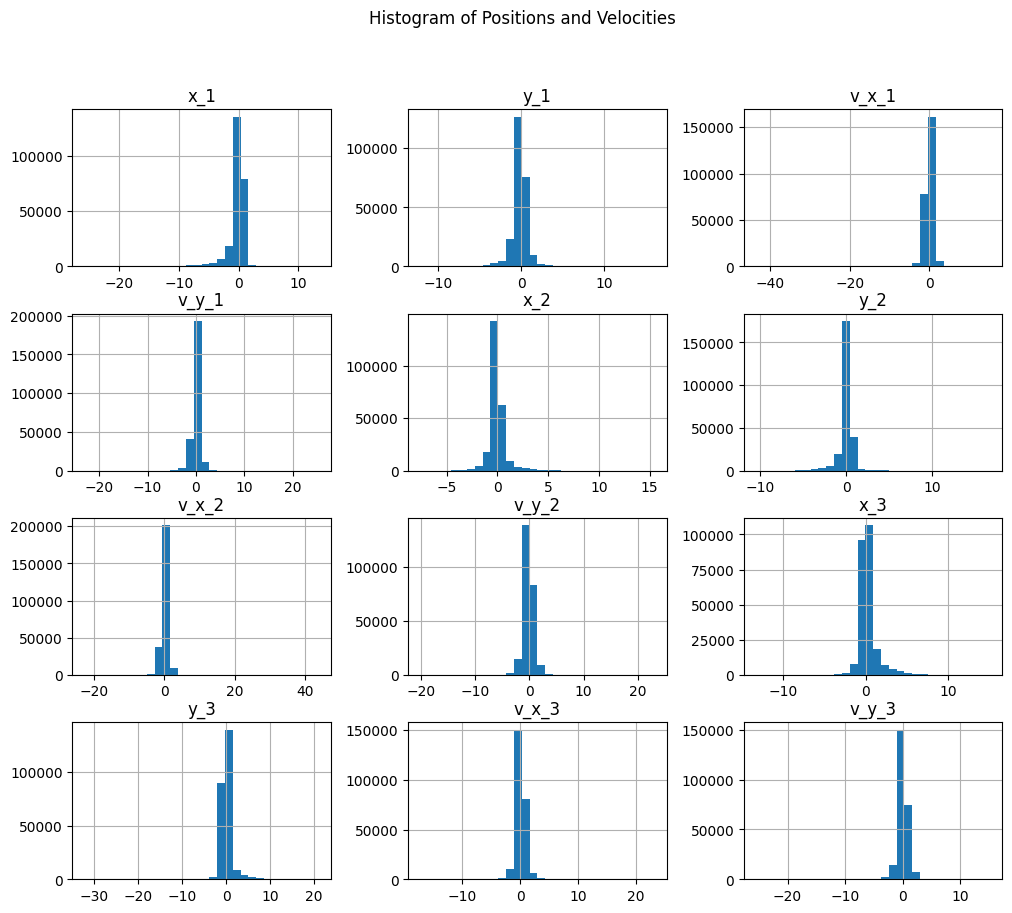

In [187]:
df[['x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3']].hist(bins=30, figsize=(12, 10))
plt.suptitle("Histogram of Positions and Velocities")
plt.show()

Correlation Matrix, to check the correlation between features

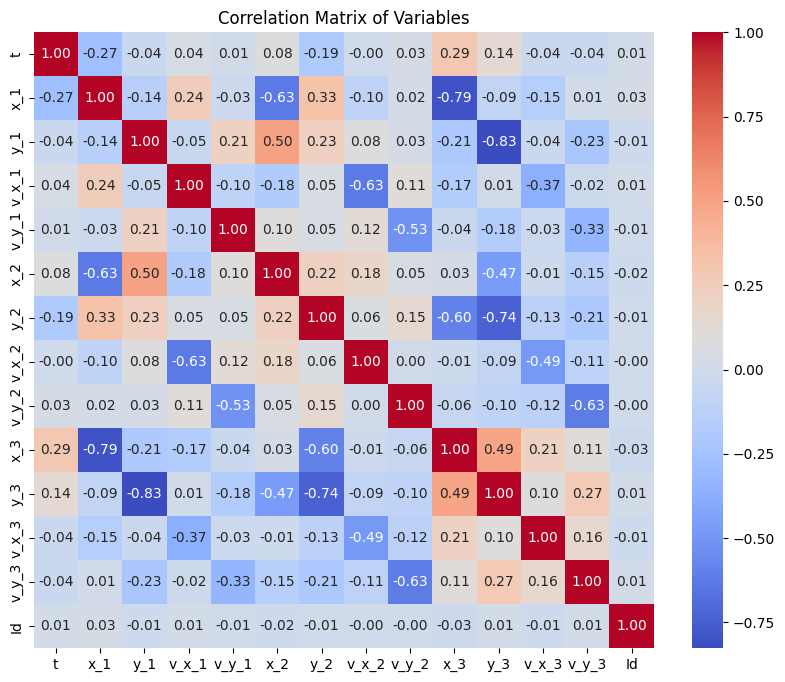

In [188]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Variables')
plt.show()

Plotting the the first forty trajectories

In [189]:
def plot_selected_trajectories(data, n1, n2, points_per_trajectory=258, point_size=0.005):
    for i in range(n1, n2):
        start_idx = i * points_per_trajectory
        end_idx = start_idx + points_per_trajectory

        traj = data.iloc[start_idx:end_idx]

        fig, ax = plt.subplots(figsize=(7, 6))

        ax.plot(traj['x_1'].iloc[0], traj['y_1'].iloc[0], color='yellow', label='Starting Points', marker='o', markersize=point_size*1000)
        ax.plot(traj['x_2'].iloc[0], traj['y_2'].iloc[0], color='yellow', marker='o', markersize=point_size*1000)
        ax.plot(traj['x_3'].iloc[0], traj['y_3'].iloc[0], color='yellow', marker='o', markersize=point_size*1000)

        ax.plot(traj['x_1'].iloc[257], traj['y_1'].iloc[257], color='orange', label='Finishing Points', marker='o', markersize=point_size*1000)
        ax.plot(traj['x_2'].iloc[257], traj['y_2'].iloc[257], color='orange', marker='o', markersize=point_size*1000)
        ax.plot(traj['x_3'].iloc[257], traj['y_3'].iloc[257], color='orange', marker='o', markersize=point_size*1000)

        ax.plot(traj['x_1'], traj['y_1'], color='red', label='Point 1', marker='o', markersize=point_size)
        ax.plot(traj['x_2'], traj['y_2'], color='blue', label='Point 2', marker='o', markersize=point_size)
        ax.plot(traj['x_3'], traj['y_3'], color='green', label='Point 3', marker='o', markersize=point_size)

        ax.set_title(f'Trajectory {i}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.legend()
        ax.grid(True)

        plt.tight_layout()
        plt.show()

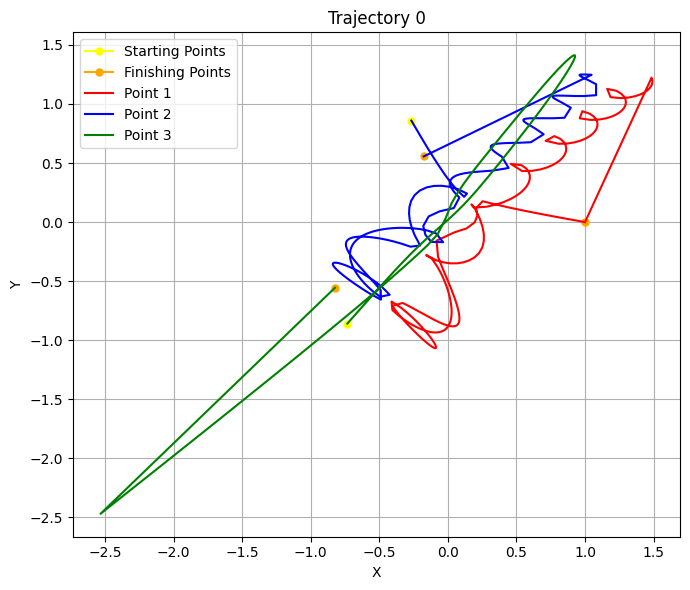

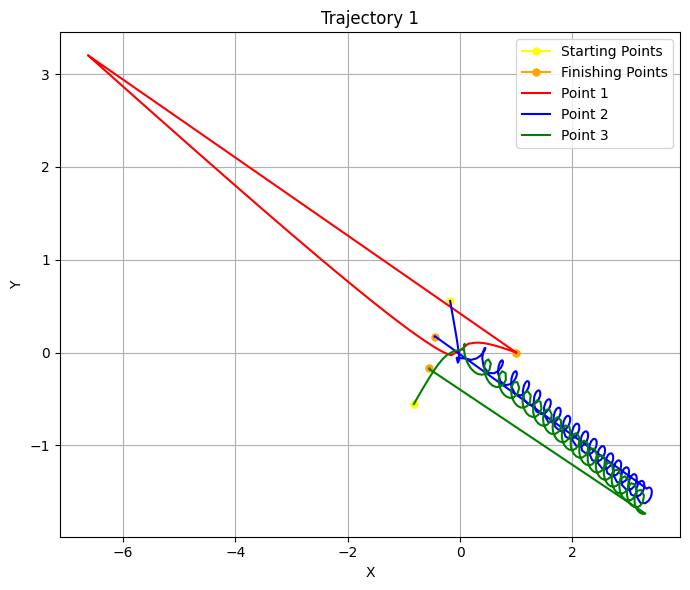

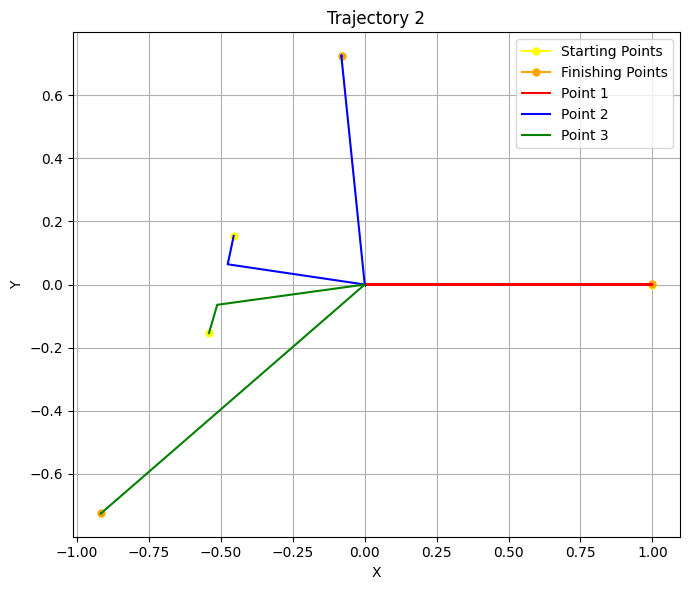

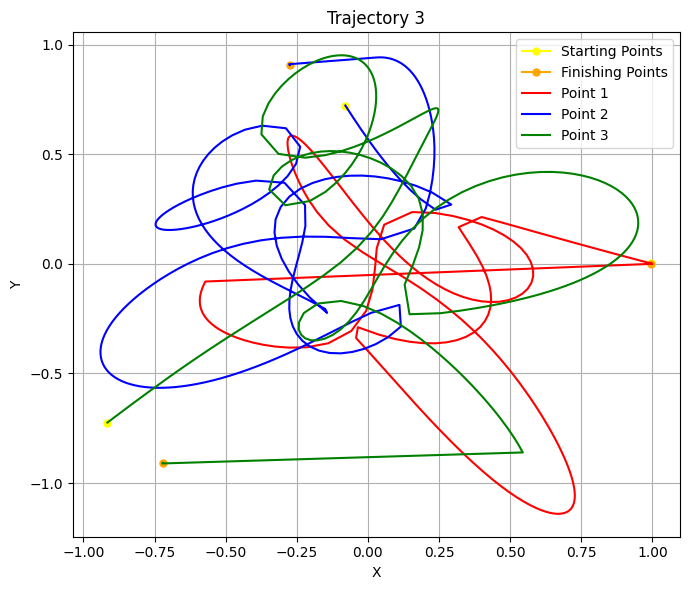

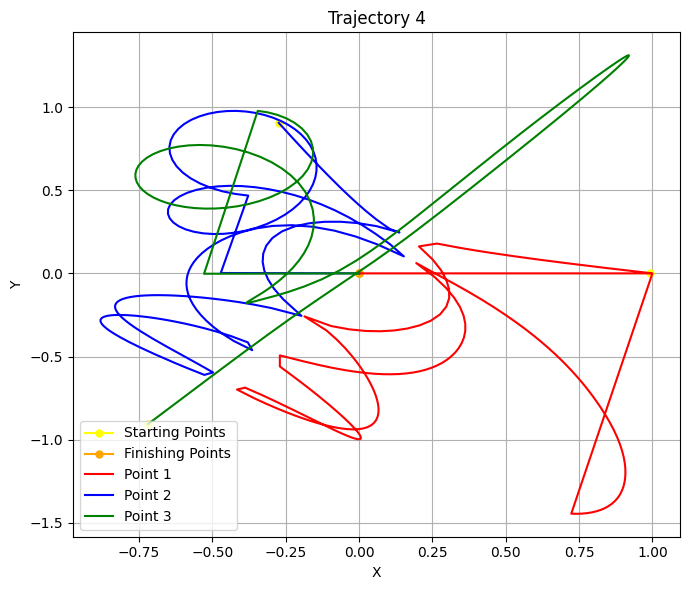

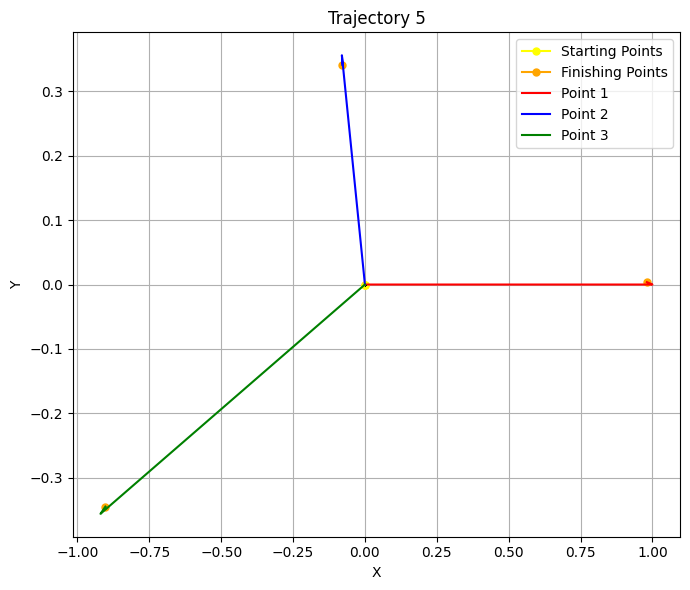

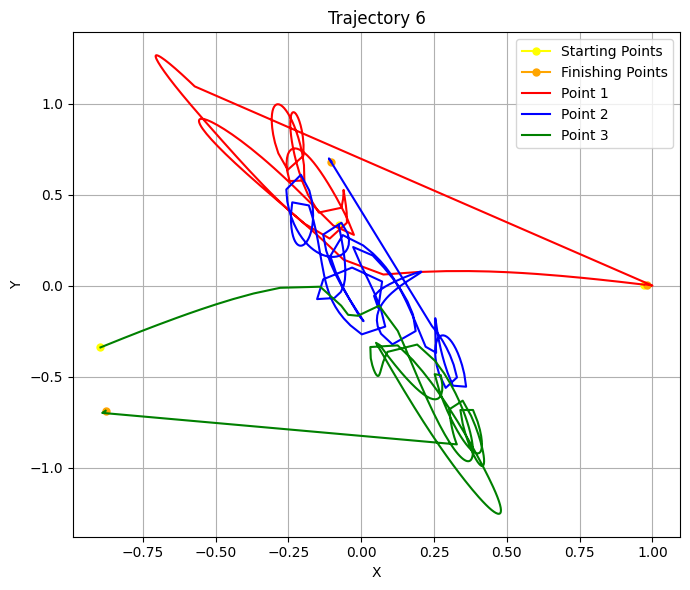

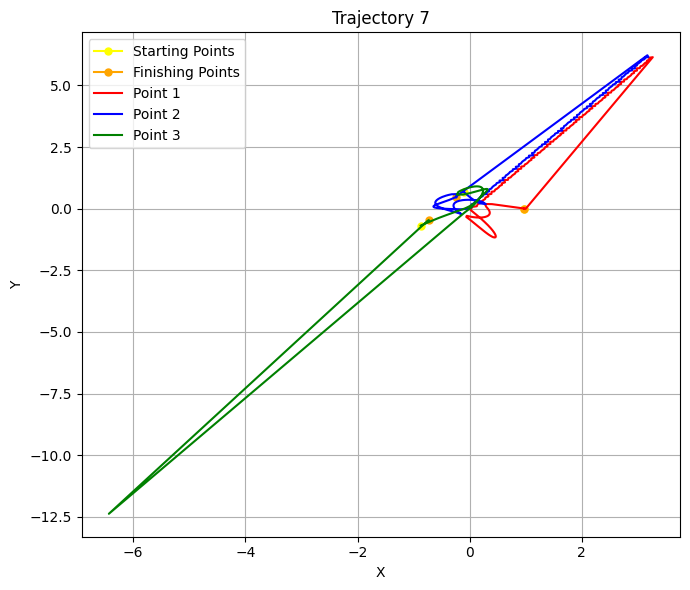

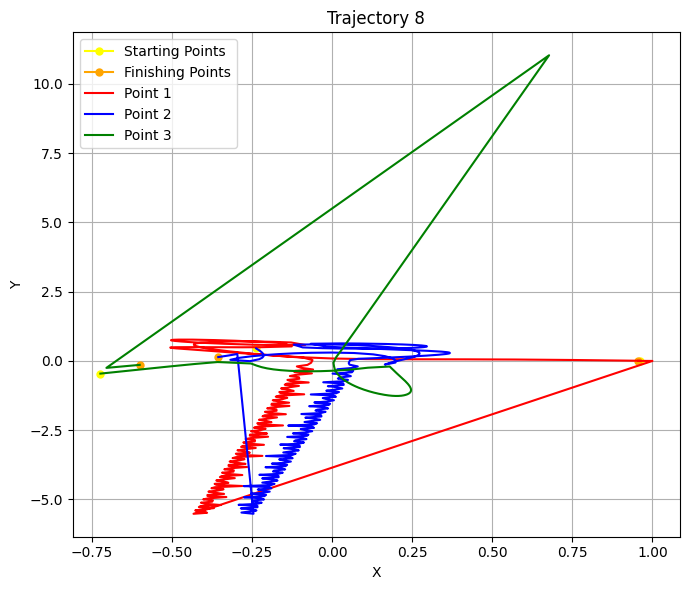

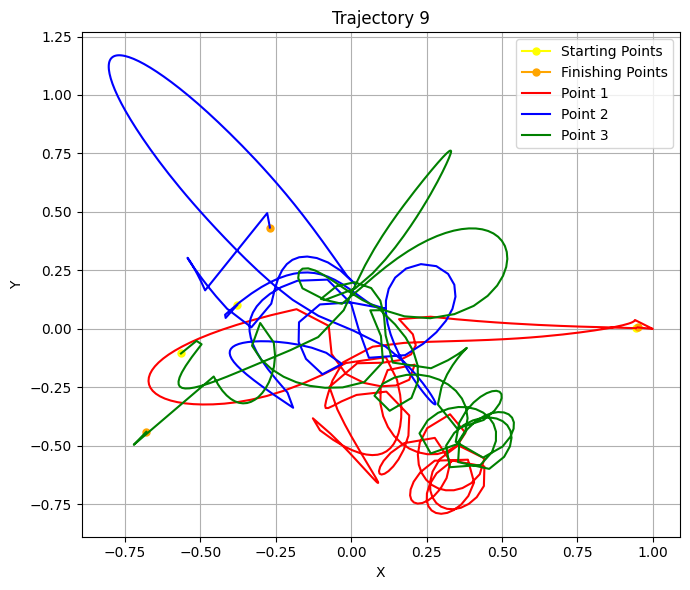

In [190]:
plot_selected_trajectories(df,0, 10)

### Train test split

In [191]:
print(df.shape)

(250084, 14)


We will add a new column that asssigns a trajectory ID to each row

In [192]:
df['TrajectoryId'] = df['Id'] // 258


In [193]:
trajectory_starts = df.groupby('TrajectoryId').head(1)
print(trajectory_starts)

               t       x_1       y_1     v_x_1     v_y_1       x_2       y_2  \
0       0.000000  1.000000  0.000000  0.000000  0.000000 -0.266467  0.859196   
258     0.039062  0.999392  0.000131 -0.031160  0.006723 -0.176326  0.555148   
516     0.078125  0.997331  0.000029 -0.068445  0.000723 -0.455692  0.154201   
774     0.117188  0.995107  0.001682 -0.083671  0.028770 -0.079342  0.722372   
1032    0.156250  0.993103  0.001384 -0.088495  0.017771 -0.273717  0.904459   
...          ...       ...       ...       ...       ...       ...       ...   
248970  7.578120 -1.547098 -2.378297  3.691723  1.755800 -1.522982 -2.419424   
249228  7.617190  0.132315 -0.412897 -0.096405 -1.008701  0.655791  0.106467   
249486  7.656250 -0.038727 -0.908570  0.207916  0.107042  0.868071  0.857111   
249744  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
250002  7.734380  1.193028 -0.471120 -0.249471  0.010704 -0.223802  0.657270   

           v_x_2     v_y_2       x_3   

In [194]:
unique_trajectories = df['TrajectoryId'].unique()


We split the trajectories in the ones that will belong to the test and the ones that will bealong to the train.

In [195]:
train_trajectories, test_trajectories = train_test_split(unique_trajectories, test_size=0.2, random_state=42)

In [196]:
train_set = df[df['TrajectoryId'].isin(train_trajectories)]
test_set = df[df['TrajectoryId'].isin(test_trajectories)]

In [197]:
train_set.head(5)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,TrajectoryId
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0.0,0.0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1.0,0.0
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2.0,0.0
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3.0,0.0
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4.0,0.0


In [198]:
test_set.head(5)

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,TrajectoryId
5934,0.898438,0.631758,0.021402,-0.993611,0.030939,-0.306310,0.196930,0.699646,1.187146,-0.325448,-0.218332,0.293965,-1.218085,5934.0,23.0
5935,0.937500,0.591315,0.022577,-1.078349,0.029330,-0.278334,0.239268,0.733541,0.991664,-0.312981,-0.261845,0.344808,-1.020993,5935.0,23.0
5936,0.976562,0.547403,0.023704,-1.171494,0.028566,-0.248925,0.275004,0.773307,0.843322,-0.298477,-0.298709,0.398187,-0.871889,5936.0,23.0
5937,1.015620,0.499657,0.024830,-1.275040,0.029420,-0.217821,0.305444,0.820655,0.717691,-0.281836,-0.330274,0.454384,-0.747110,5937.0,23.0
5938,1.054690,0.447621,0.026041,-1.391599,0.033237,-0.184690,0.331193,0.877403,0.601298,-0.262932,-0.357234,0.514196,-0.634535,5938.0,23.0


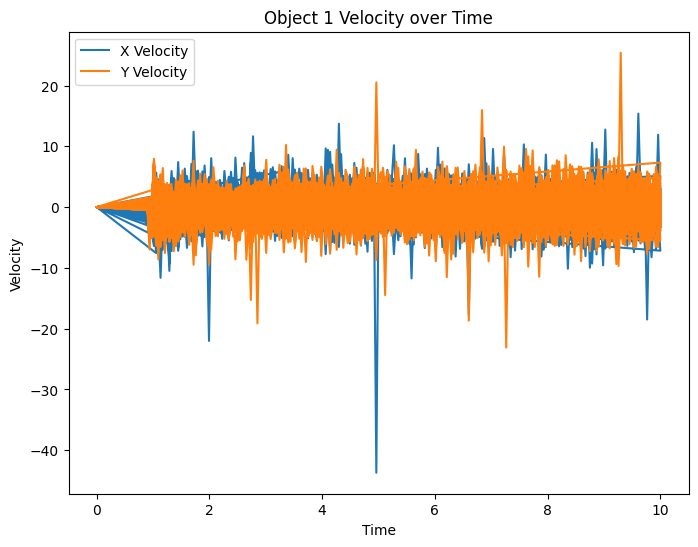

In [199]:
# @title Object 1 Velocity over Time

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(df['t'], df['v_x_1'], label='X Velocity')
plt.plot(df['t'], df['v_y_1'], label='Y Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Object 1 Velocity over Time')
_ = plt.legend()

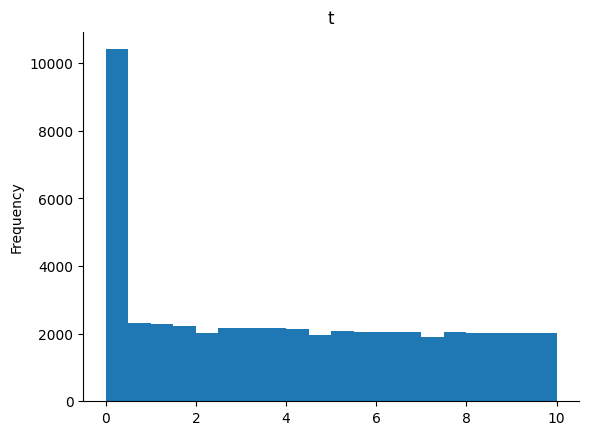

In [200]:

from matplotlib import pyplot as plt
test_set['t'].plot(kind='hist', bins=20, title='t')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [201]:
position_columns = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
velocity_columns = ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']

In [202]:
X_train = train_set.drop(columns= position_columns + ['TrajectoryId'])
y_train = train_set[position_columns]

In [203]:
X_test = test_set.drop(columns=position_columns + ['TrajectoryId'])
y_test = test_set[position_columns]

In [204]:
print("Shape of the X Train :", X_train.shape)
print("Shape of the y Train :", y_train.shape)
print("Shape of the X test :", X_test.shape)
print("Shape of the y test :", y_test.shape)

Shape of the X Train : (200032, 8)
Shape of the y Train : (200032, 6)
Shape of the X test : (50052, 8)
Shape of the y test : (50052, 6)


Now we will slip the train into the data that we will use to train the model, and the data we will use for validation

In [205]:
X_train_samp, X_val, y_train_samp, y_val = train_test_split(X_train, y_train, test_size=0.2)

### Pipeline

We did two functions to make cross validation to be able to evaluate the models. We

In [206]:
def execute_model_pipeline(model, X_train, y_train, use_scaler=False, cv_folds=5):
    steps = [('scaler', StandardScaler())] if use_scaler else []
    steps.append(('model', model))

    pipeline = Pipeline(steps)

    scoring = {
        'r2': 'r2',
        'mse': make_scorer(mean_squared_error),
        'mae': make_scorer(mean_absolute_error)
    }

    cv_results = cross_validate(pipeline, X_train, y_train, cv=cv_folds, scoring=scoring, return_train_score=True)
    return cv_results

In [213]:
def print_evaluation_metrics(cv_results, X_train):
    n = X_train.shape[0]
    p = X_train.shape[1]

    for metric in ['r2', 'mse', 'mae']:
        train_mean = np.mean(cv_results[f'train_{metric}'])
        test_mean = np.mean(cv_results[f'test_{metric}'])
        train_std = np.std(cv_results[f'train_{metric}'])
        test_std = np.std(cv_results[f'test_{metric}'])

        print(f"Mean {metric.upper()} (val): {test_mean:.4f} (±{test_std:.4f})")

        if metric == 'r2':
            test_r2_adjusted = np.mean([1 - (1 - score)*(n - 1)/(n - p - 1) for score in cv_results[f'test_{metric}']])
            print(f"Mean R^2 Ajusted (val): {test_r2_adjusted:.4f}")

        if metric == 'mse':
            rmse_train_mean = np.sqrt(train_mean)
            rmse_test_mean = np.sqrt(test_mean)
            rmse_train_std = np.sqrt(train_std)
            rmse_test_std = np.sqrt(test_std)

            print(f"Mean RMSE (train): {rmse_train_mean:.4f} (±{rmse_train_std:.4f})")
            print(f"Mean RMSE (val): {rmse_test_mean:.4f} (±{rmse_test_std:.4f})")


In [208]:
def parameter_grid_search(model, param_grid, X_train, y_train, use_scaler=False, cv_folds=5, scoring='r2'):
    steps = [('scaler', StandardScaler())] if use_scaler else []
    steps.append(('model', model))
    pipeline = Pipeline(steps)

    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring=scoring, return_train_score=True)
    grid_search.fit(X_train, y_train)

    return grid_search

### Baseline Model

In [209]:
linear_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

linear_model.fit(X_train_samp, y_train_samp)

y_val_pred_linear = linear_model.predict(X_val)

rmse_val_linear = np.sqrt(mean_squared_error(y_val, y_val_pred_linear))
print('RMSE linear regression ',rmse_val_linear)

RMSE linear regression  1.2607774330024508


In [210]:
def plot_y_yhat(y_val, y_val_pred_linear, plot_title="plot"):
    labels = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
    MAX = 500
    if len(y_val) > MAX:
        # Use .iloc to select rows by numerical index
        idx = np.random.choice(len(y_val), MAX, replace=False)
        y_val_subset = y_val.iloc[idx] # Select a subset of the DataFrame
        y_val_pred_linear_subset = y_val_pred_linear[idx]
    else:
        y_val_subset = y_val  # Use the entire DataFrame if it's small
        y_val_pred_linear_subset = y_val_pred_linear
    plt.figure(figsize=(10, 10))
    for i in range(6):
        # Access columns by name using the labels list
        x0 = np.min(y_val_subset[labels[i]])
        x1 = np.max(y_val_subset[labels[i]])
        plt.subplot(3, 2, i + 1)
        # Plot using the subsets
        plt.scatter(y_val_subset[labels[i]], y_val_pred_linear_subset[:, i])
        plt.xlabel('True ' + labels[i])
        plt.ylabel('Predicted ' + labels[i])
        plt.plot([x0, x1], [x0, x1], color='red')
        plt.axis('square')
    plt.savefig(plot_title + '.pdf')
    plt.show()

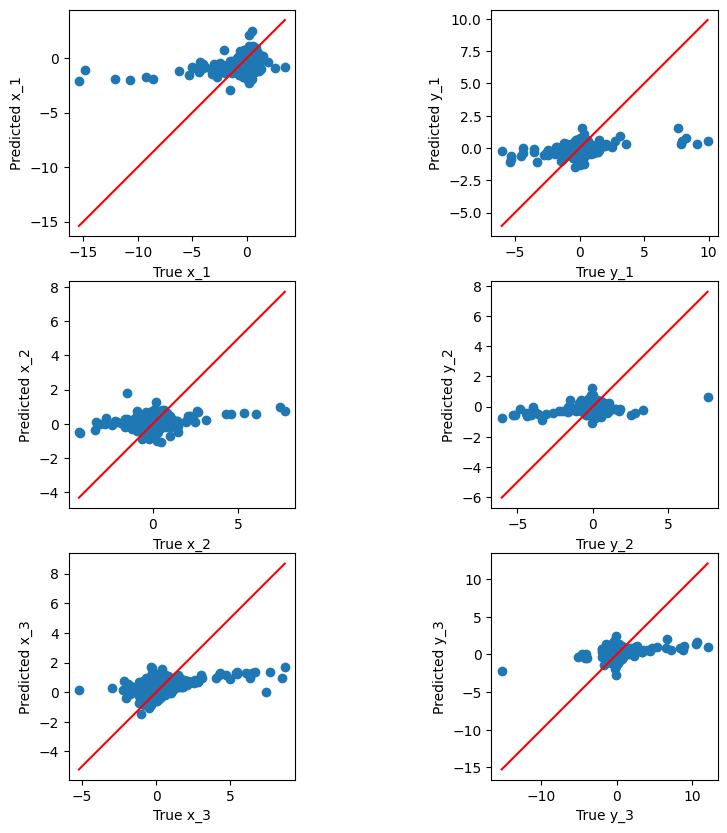

In [211]:
plot_y_yhat(y_val,y_val_pred_linear, plot_title = "plot")

Trying cross validation to see the model results:

In [214]:
reg_model=LinearRegression()
scores = execute_model_pipeline(reg_model, X_train_samp, y_train_samp, use_scaler=True)
print_evaluation_metrics(scores, X_train_samp)

Mean R2 (val): 0.1105 (±0.0027)
Mean R^2 Ajusted (val): 0.1104
Mean MSE (val): 1.5101 (±0.0435)
Mean RMSE (train): 1.2286 (±0.1042)
Mean RMSE (val): 1.2289 (±0.2085)
Mean MAE (val): 0.7011 (±0.0028)


# Task 2

## Regularization

### Ridge

Performing a grid search to look for the regularization paramterer that gives us the best results

In [215]:
alpha_space = np.logspace(-4, 0, 50)
param_grid = {'model__alpha': alpha_space}
res = parameter_grid_search(Ridge(), param_grid, X_train, y_train, use_scaler=True, cv_folds=5, scoring='neg_root_mean_squared_error')

In [216]:
best_params = res.best_params_
print('Best regularization parameter', best_params)

best_score = res.best_score_
print('Best RMSE of the search for the best regularization parameter', best_score)

Best regularization parameter {'model__alpha': 1.0}
Best RMSE of the search for the best regularization parameter -1.208976784520055


In [99]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

ridge_pipeline.fit(X_train_samp, y_train_samp)

y_val_pred_ridge = ridge_pipeline.predict(X_val)

rmse_val_ridge = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge))
print('RMSE ridge regularization ',rmse_val_ridge)

RMSE ridge regularization  1.216802776085043


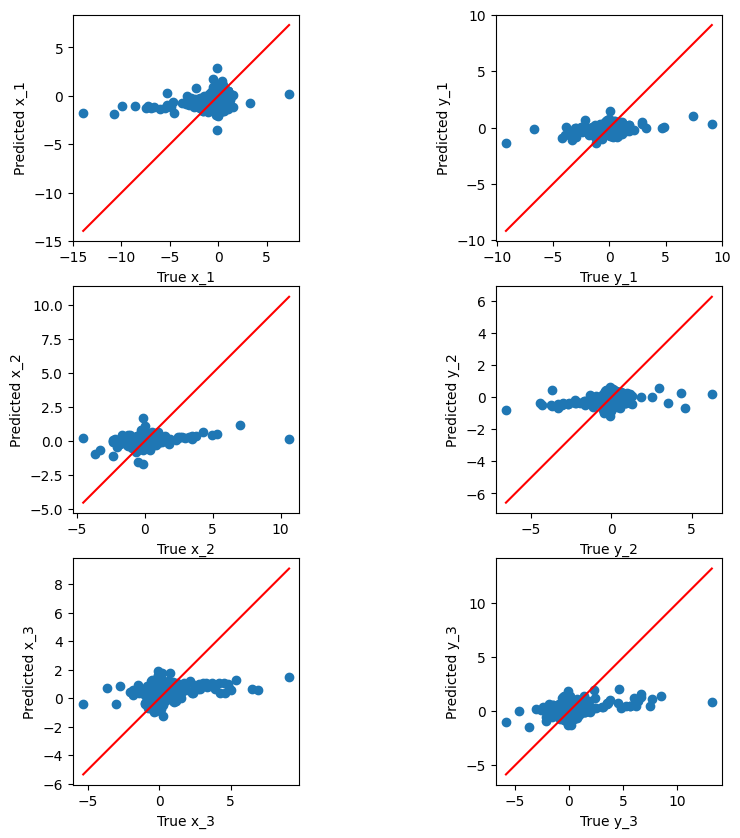

In [100]:
plot_y_yhat(y_val,y_val_pred_ridge, plot_title = "plot")

In [222]:
reg_model=Ridge(alpha=1.0)
scores = execute_model_pipeline(reg_model, X_train_samp, y_train_samp, use_scaler=True)
print_evaluation_metrics(scores, X_train_samp)

Mean R2 (val): 0.1079 (±0.0023)
Mean R^2 Ajusted (val): 0.1079
Mean MSE (val): 1.5152 (±0.0446)
Mean RMSE (train): 1.2307 (±0.1056)
Mean RMSE (val): 1.2309 (±0.2113)
Mean MAE (val): 0.7005 (±0.0030)


### Lasso

In [217]:
alpha_space = np.logspace(-1, 0, 10)
param_grid = {'model__alpha': alpha_space}
res = parameter_grid_search(Lasso(), param_grid, X_train_samp, y_train_samp, use_scaler=True, cv_folds=5, scoring='neg_root_mean_squared_error')

In [218]:
best_params = res.best_params_
print('Best regularization parameter', best_params)

best_score = res.best_score_
print('Best RMSE of the search for the best regularization parameter', best_score)

Best regularization parameter {'model__alpha': 0.1}
Best RMSE of the search for the best regularization parameter -1.2163969757886612


In [219]:
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Lasso(alpha=0.1))
])

lasso_pipeline.fit(X_train_samp, y_train_samp)

y_val_pred_lasso = lasso_pipeline.predict(X_val)

rmse_val_lasso = np.sqrt(mean_squared_error(y_val, y_val_pred_lasso))
print('RMSE lasso regularization ',rmse_val_lasso)

RMSE lasso regularization  1.2755917918629291


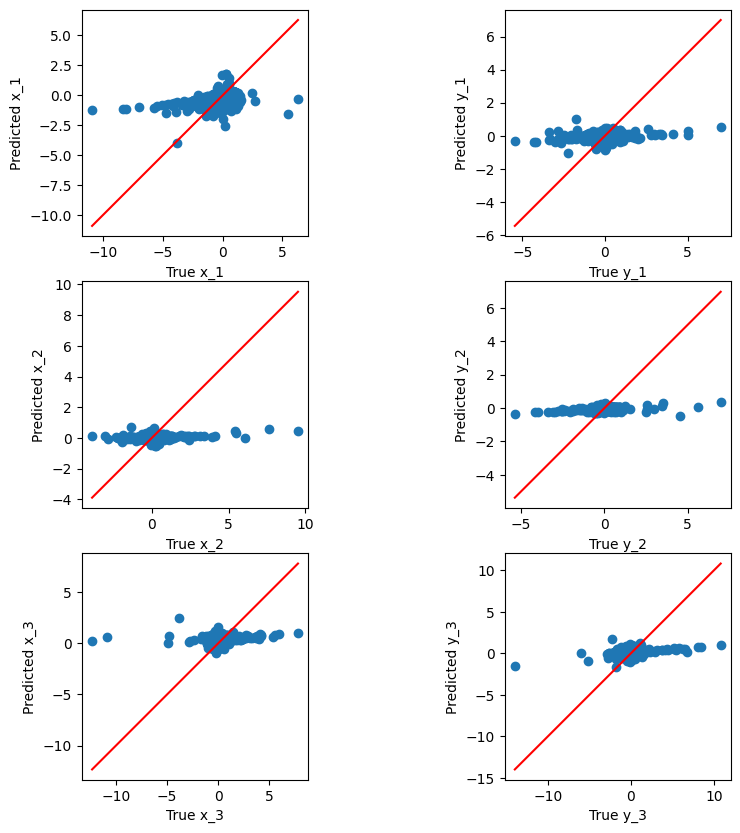

In [220]:
plot_y_yhat(y_val,y_val_pred_lasso, plot_title = "plot")

In [223]:
reg_model=Lasso(alpha=0.1)
scores = execute_model_pipeline(reg_model, X_train_samp, y_train_samp, use_scaler=True)
print_evaluation_metrics(scores, X_train_samp)

Mean R2 (val): 0.0868 (±0.0006)
Mean R^2 Ajusted (val): 0.0867
Mean MSE (val): 1.5459 (±0.0483)
Mean RMSE (train): 1.2432 (±0.1050)
Mean RMSE (val): 1.2433 (±0.2197)
Mean MAE (val): 0.6669 (±0.0033)


## Polynomial features

In [224]:
def validate_poly_regression(X_train1, y_train1, X_val, y_val, regressor=None, degrees=range(1,5), max_features=None):
  sample_frac = 0.1

  X_train = X_train1.sample(frac=sample_frac, random_state=42)
  y_train = y_train1.loc[X_train.index]

  regressor=Ridge(alpha=1.0)
  mses_val = {}
  mses_train = {}
  val_preds = {}
  train_preds = {}
  true_val = {}
  true_train = {}


  for degree in range(1,15):
            pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('regressor', regressor)
        ])
            pipeline.fit(X_train, y_train)

            n_output_features = pipeline.named_steps['poly'].n_output_features_
            print(f"Degree {degree}: Number of characteristics = {n_output_features}")

            train_preds[degree] = pipeline.predict(X_train)
            val_preds[degree] = pipeline.predict(X_val)


            true_train[degree] = y_train
            true_val[degree] = y_val

            mses_train[degree] = mean_squared_error(y_train, train_preds[degree], squared=False)
            mses_val[degree] = mean_squared_error(y_val, val_preds[degree], squared=False)

            print(f"Degree {degree}: RMSE train = {mses_train[degree]:.4f}, RMSE validation = {mses_val[degree]:.4f}")
  return mses_train, mses_val, train_preds, val_preds, true_train, true_val



In [225]:
mses_train, mses_val, train_preds, val_preds, true_train, true_val = validate_poly_regression(X_train_samp, y_train_samp, X_val, y_val)


Degree 1: Number of characteristics = 8
Degree 1: RMSE train = 1.2005, RMSE validation = 1.2359
Degree 2: Number of characteristics = 44
Degree 2: RMSE train = 1.1546, RMSE validation = 1.2092
Degree 3: Number of characteristics = 164
Degree 3: RMSE train = 1.1017, RMSE validation = 1.5256
Degree 4: Number of characteristics = 494
Degree 4: RMSE train = 1.0343, RMSE validation = 5.8996
Degree 5: Number of characteristics = 1286
Degree 5: RMSE train = 0.9665, RMSE validation = 80.7876
Degree 6: Number of characteristics = 3002
Degree 6: RMSE train = 0.8864, RMSE validation = 898.5637
Degree 7: Number of characteristics = 6434
Degree 7: RMSE train = 0.7961, RMSE validation = 14724.0600


KeyboardInterrupt: 

In [41]:
polynomial_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', Ridge(alpha=1.0))
])

polynomial_pipeline.fit(X_train_samp, y_train_samp)

y_val_pred_poli = polynomial_pipeline.predict(X_val)

rmse_val_poli = np.sqrt(mean_squared_error(y_val, y_val_pred_poli))
print('RMSE polynomial ',rmse_val_poli)

RMSE polynomial  1.196301383456029


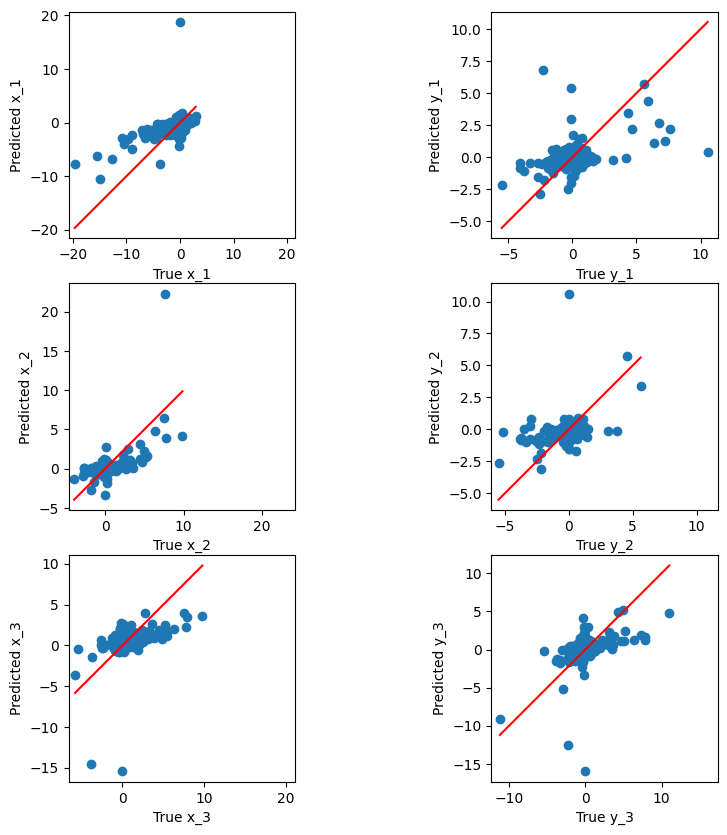

In [40]:

plot_y_yhat(y_val,y_val_pred_poli, plot_title = "plot")

# Task 3

## Feature Engineering

### Removing variables

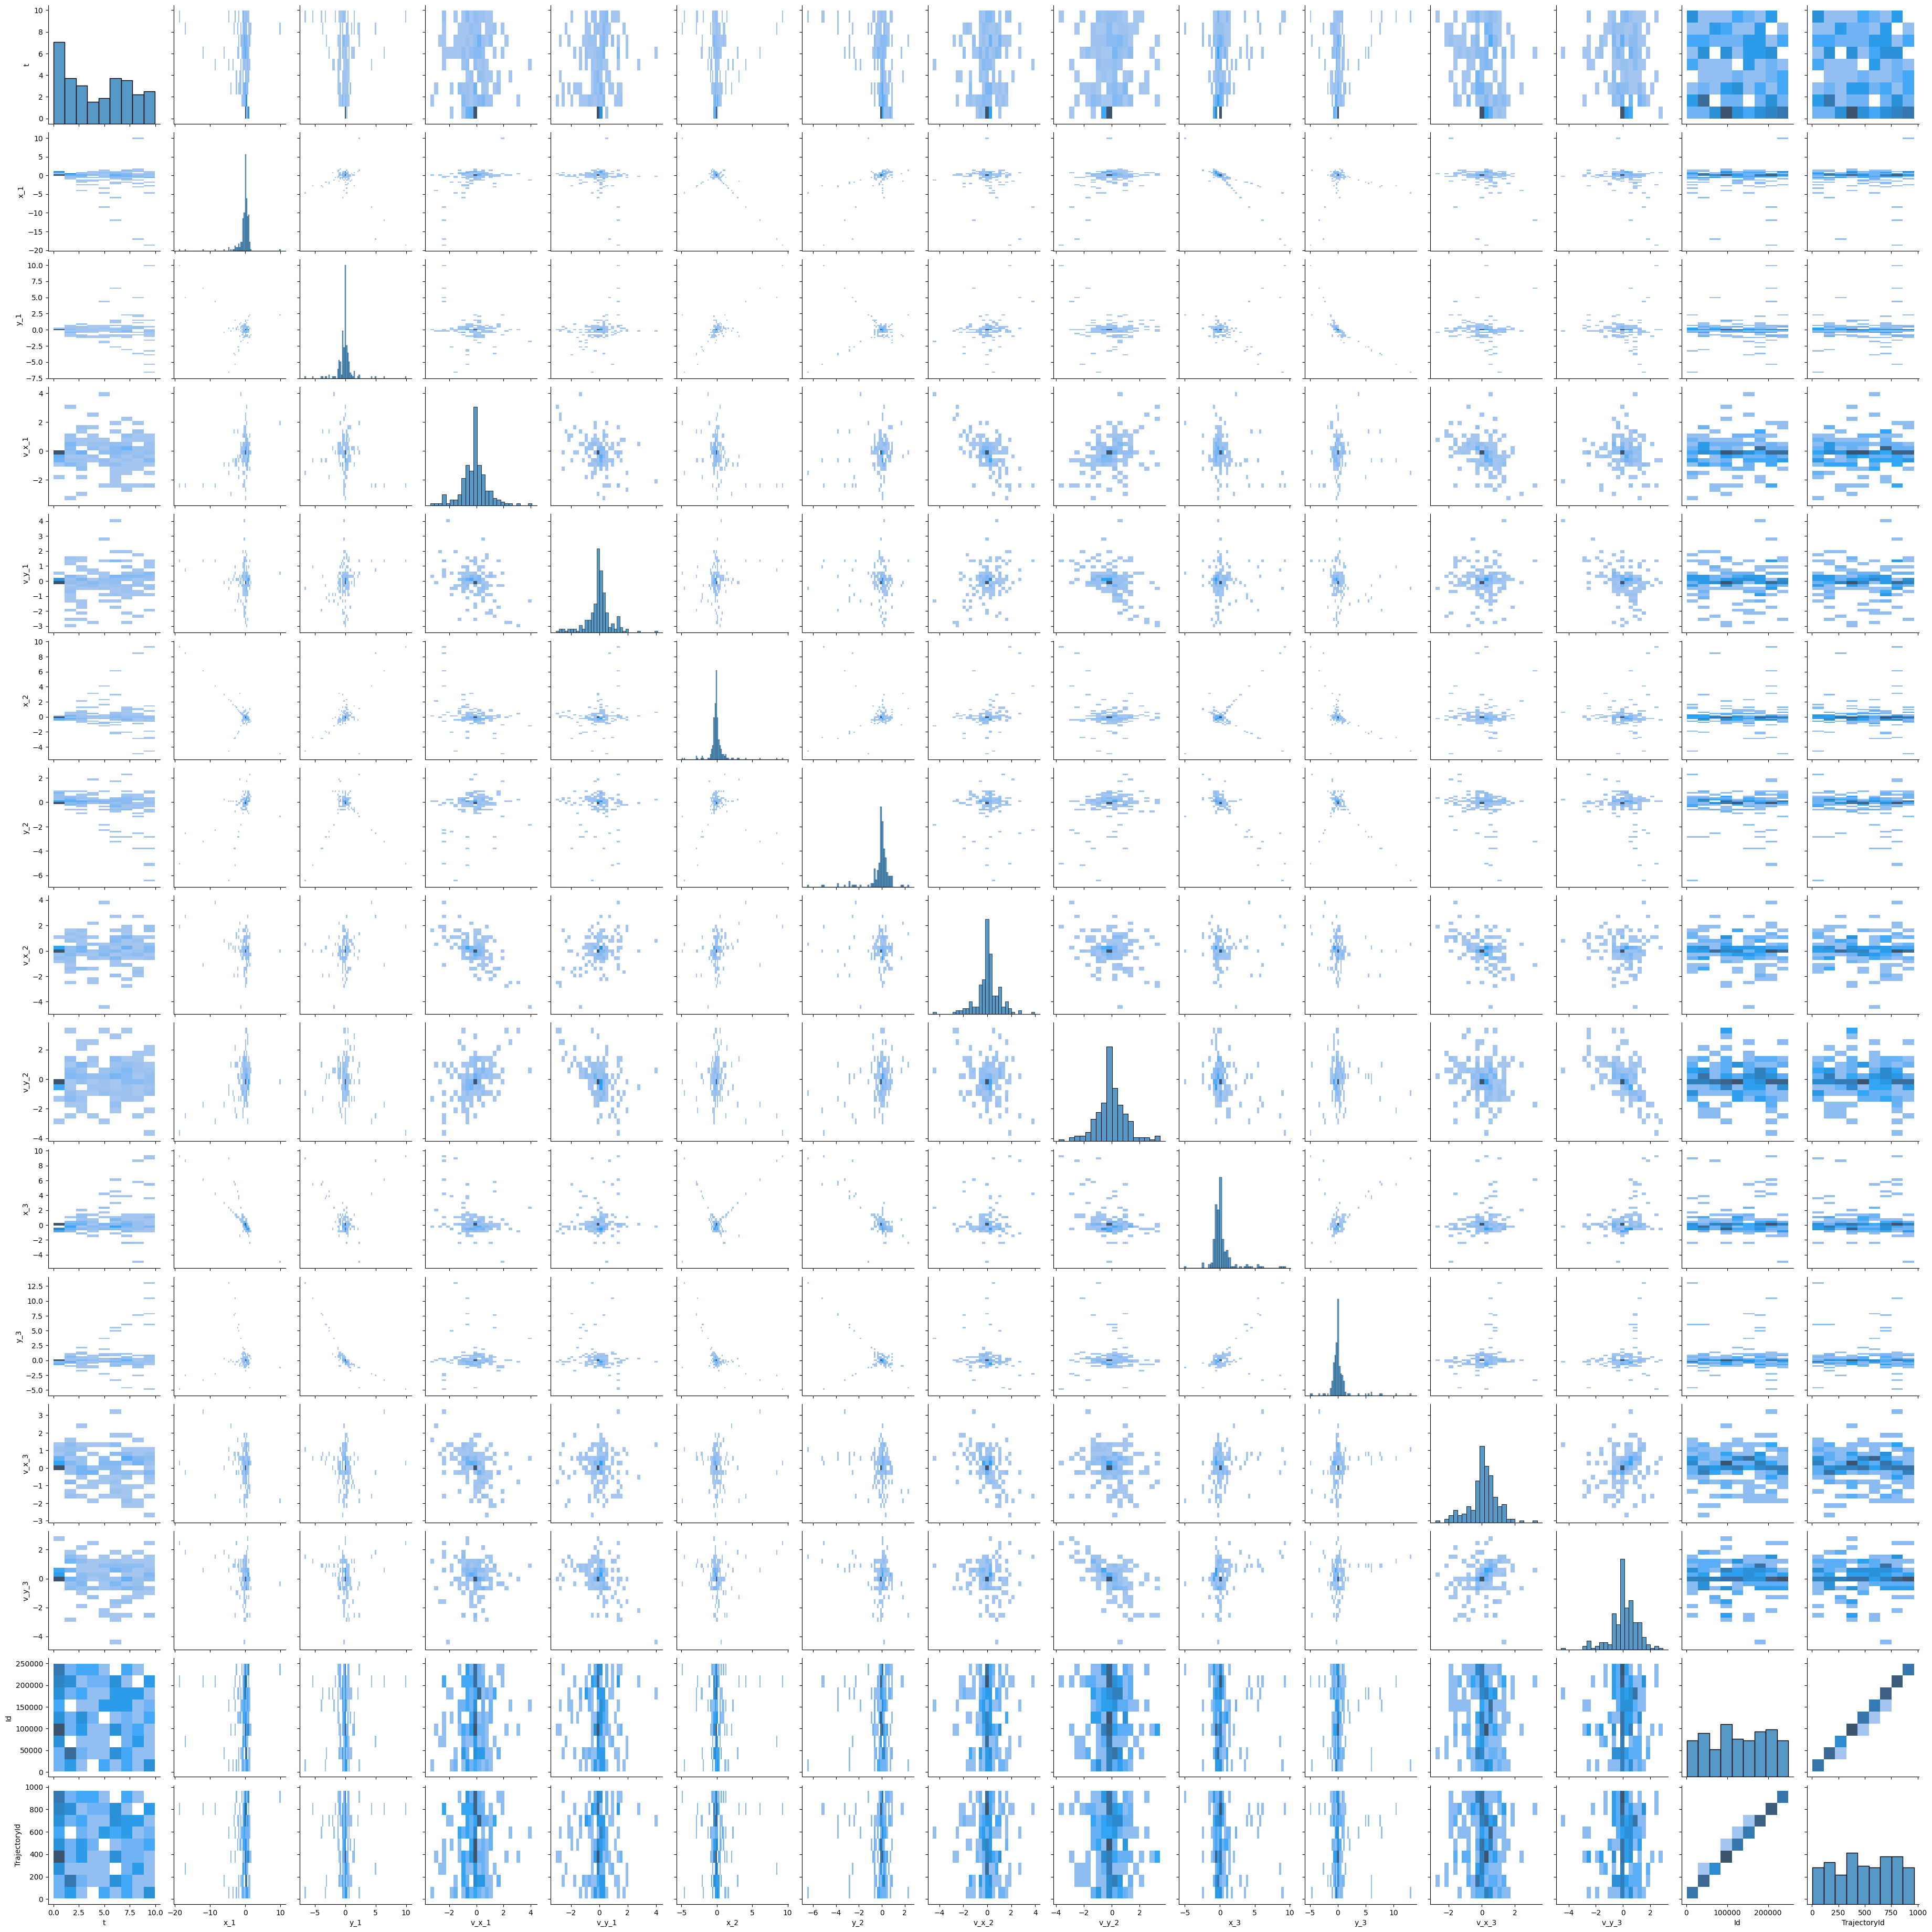

In [45]:
sns.pairplot(df.sample(200), kind="hist")

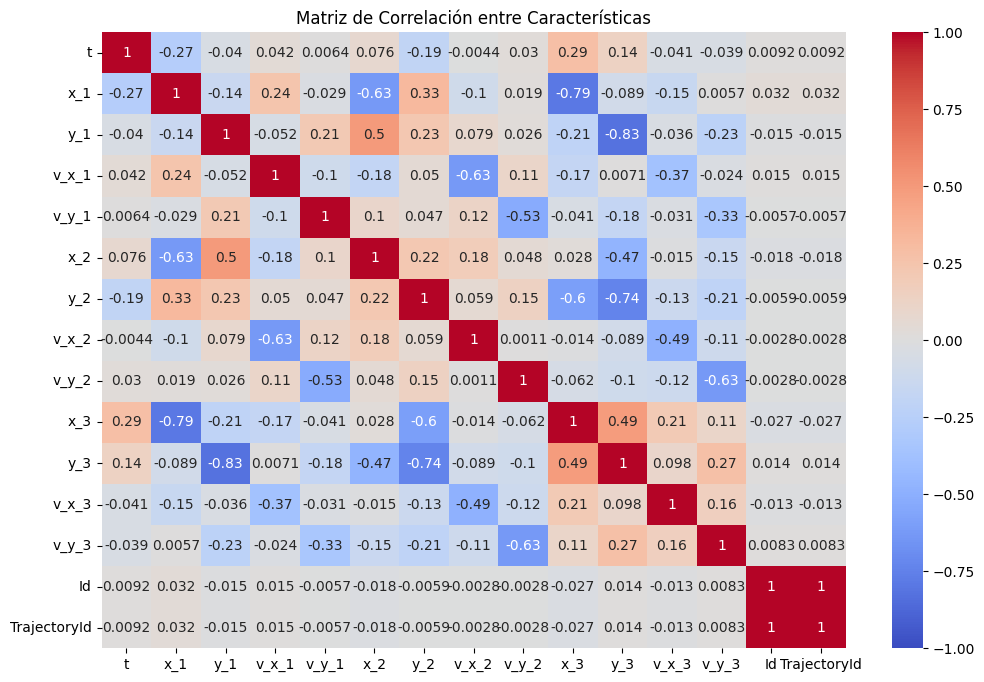

In [47]:
corr = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

Sorting the interactions by the absolute value of the correlations.

In [58]:
for target in position_columns:
    corr_target = df.corr()[target].abs().sort_values(ascending=False)
    print('Correlations with', target)
    print(corr_target, "\n")

Correlations with x_1
x_1             1.000000
x_3             0.793298
x_2             0.631014
y_2             0.326710
t               0.270208
v_x_1           0.244687
v_x_3           0.154776
y_1             0.143995
v_x_2           0.100039
y_3             0.089282
TrajectoryId    0.032255
Id              0.032252
v_y_1           0.029110
v_y_2           0.018893
v_y_3           0.005716
Name: x_1, dtype: float64 

Correlations with y_1
y_1             1.000000
y_3             0.826656
x_2             0.497703
y_2             0.231935
v_y_3           0.225005
v_y_1           0.214280
x_3             0.205061
x_1             0.143995
v_x_2           0.079134
v_x_1           0.052085
t               0.039997
v_x_3           0.036059
v_y_2           0.025734
Id              0.014855
TrajectoryId    0.014844
Name: y_1, dtype: float64 

Correlations with x_2
x_2             1.000000
x_1             0.631014
y_1             0.497703
y_3             0.474285
y_2             0.224092
v_x

RMSEs: 1.2616


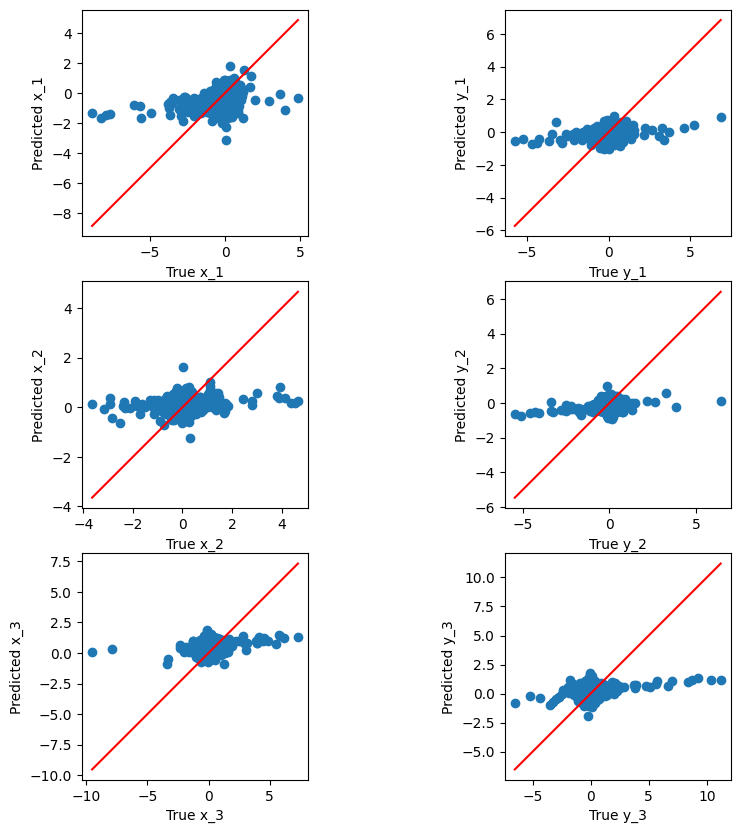

In [226]:
columns_to_drop = ['v_y_2']
X_train_reduced = X_train_samp.drop(columns=columns_to_drop)
X_val_reduced = X_val.drop(columns=columns_to_drop)

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSEs: {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced")

RMSE del modelo con características reducidas: 1.2616


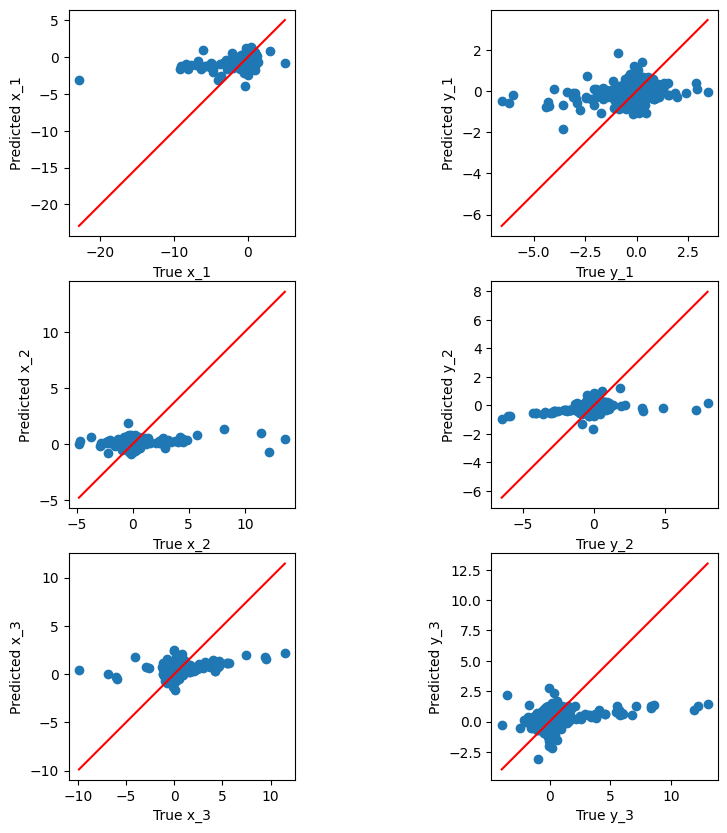

In [227]:
columns_to_drop = ['v_y_3']
X_train_reduced = X_train_samp.drop(columns=columns_to_drop)
X_val_reduced = X_val.drop(columns=columns_to_drop)

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE : {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced")

RMSE del modelo con características reducidas: 1.2368


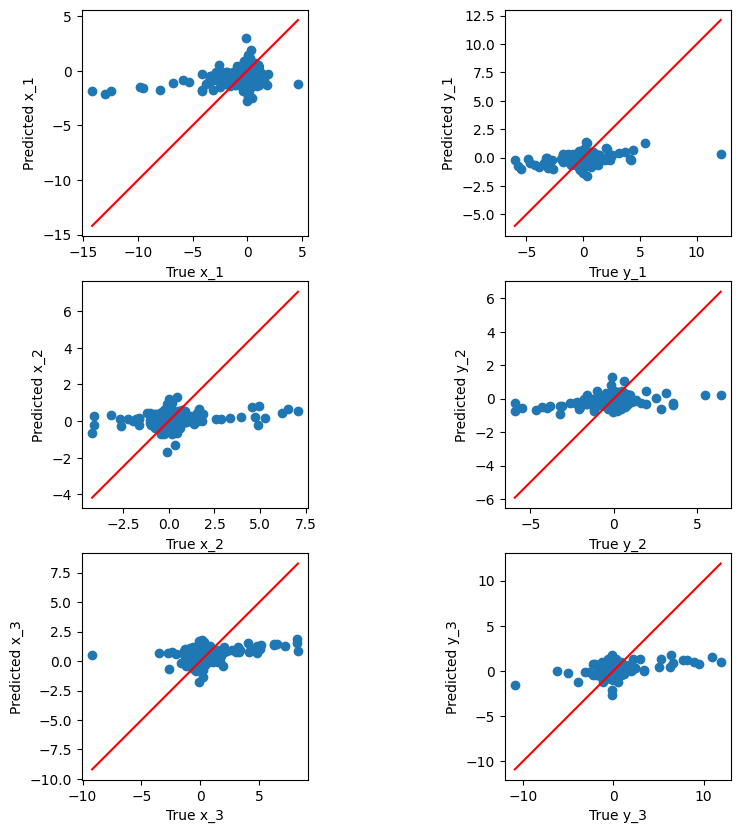

In [94]:
columns_to_drop = ['v_y_1']
X_train_reduced = X_train_samp.drop(columns=columns_to_drop)
X_val_reduced = X_val.drop(columns=columns_to_drop)

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE : {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced")


RMSE del modelo con características reducidas: 1.2407


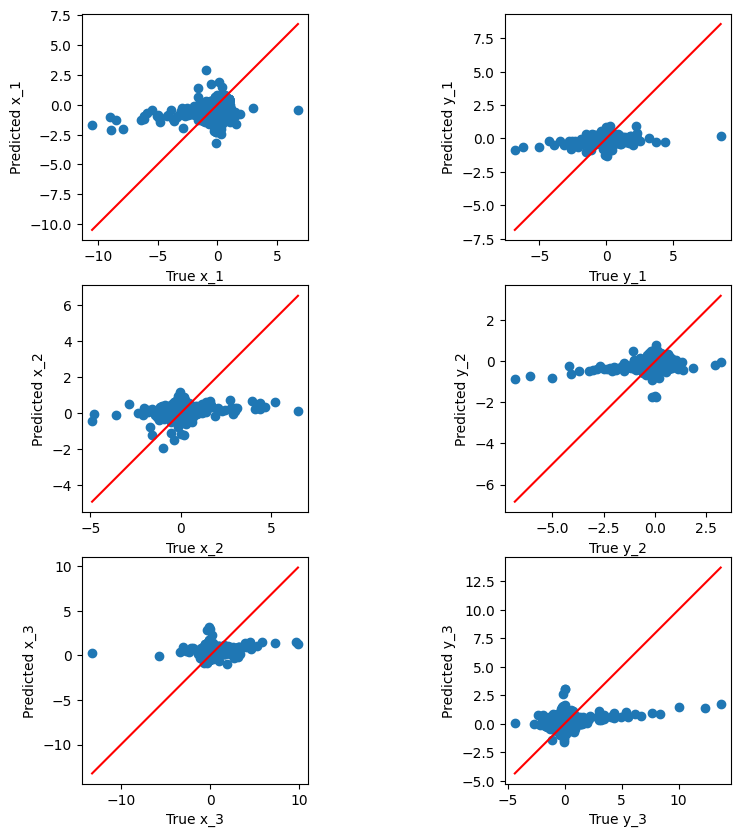

In [91]:
columns_to_drop = ['v_y_1', 'v_y_2']
X_train_reduced = X_train_samp.drop(columns=columns_to_drop)
X_val_reduced = X_val.drop(columns=columns_to_drop)

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced")

RMSE del modelo con características reducidas: 1.2376


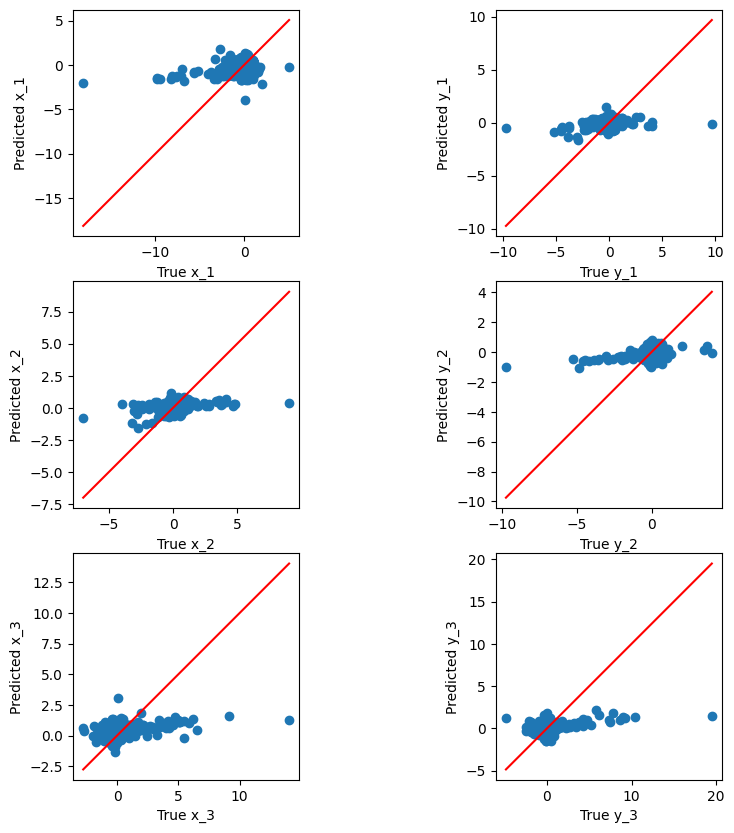

In [68]:
columns_to_drop = ['v_x_2']
X_train_reduced = X_train_samp.drop(columns=columns_to_drop)
X_val_reduced = X_val.drop(columns=columns_to_drop)

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE: {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced")


RMSE del modelo con características reducidas: 1.2621


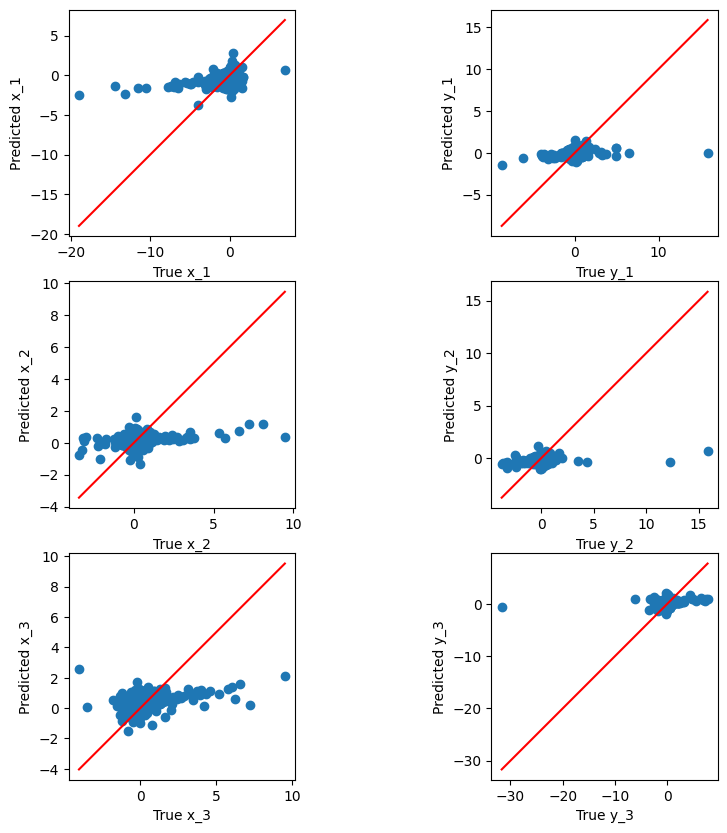

In [228]:
columns_to_drop = ['v_x_3']
X_train_reduced = X_train_samp.drop(columns=columns_to_drop)
X_val_reduced = X_val.drop(columns=columns_to_drop)

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE: {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced")


RMSE : 1.2673


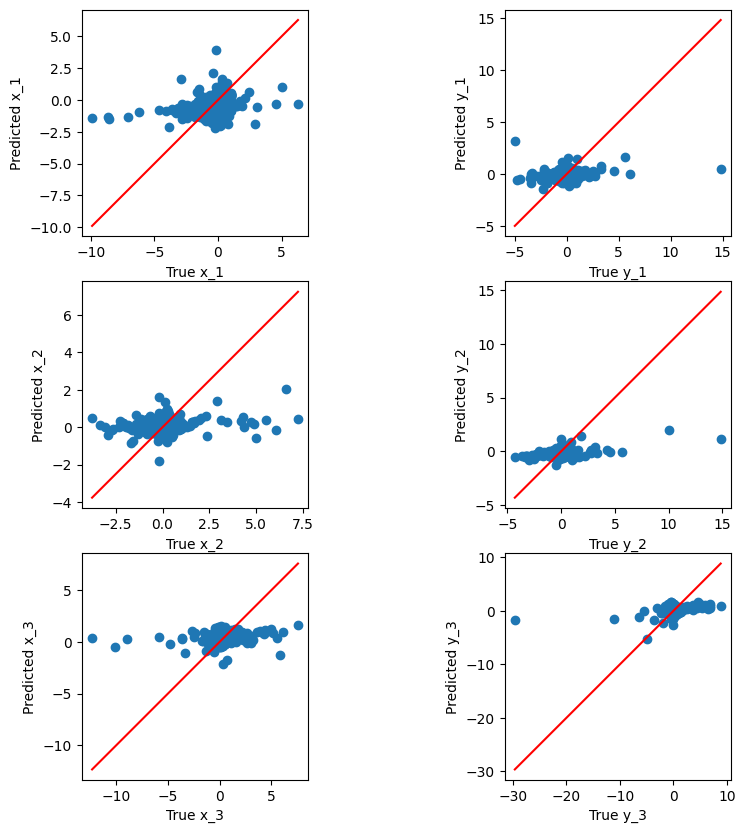

In [229]:
columns_to_drop = ['v_x_2', 'v_x_3']
X_train_reduced = X_train_samp.drop(columns=columns_to_drop)
X_val_reduced = X_val.drop(columns=columns_to_drop)

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE : {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced")


RMSE del modelo con características reducidas: 1.2380


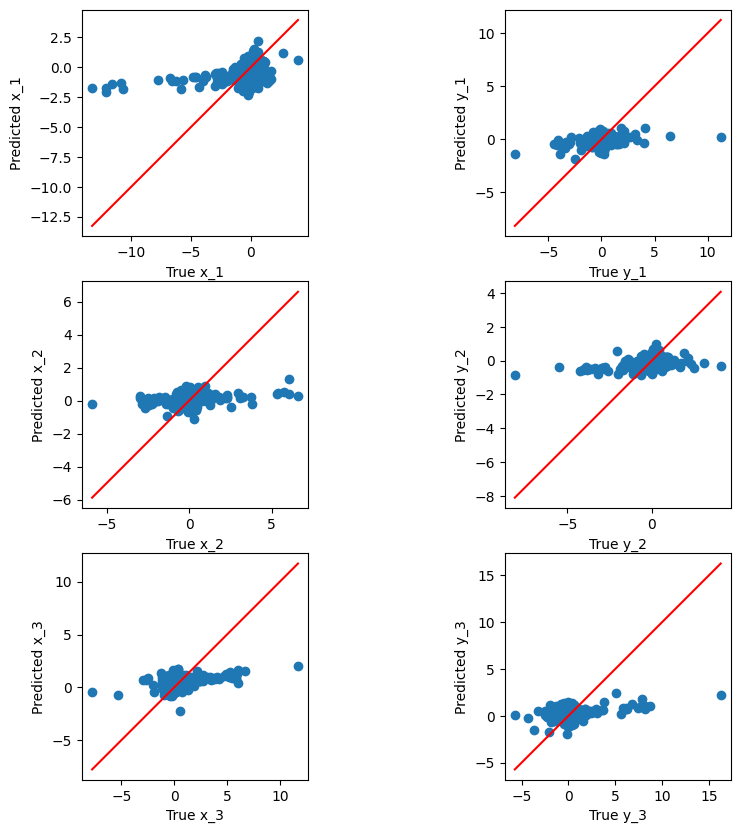

In [75]:
columns_to_drop = ['v_x_1', 'Id']
X_train_reduced = X_train_samp.drop(columns=columns_to_drop)
X_val_reduced = X_val.drop(columns=columns_to_drop)

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE s: {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced")


RMSE del modelo con características reducidas: 1.2384


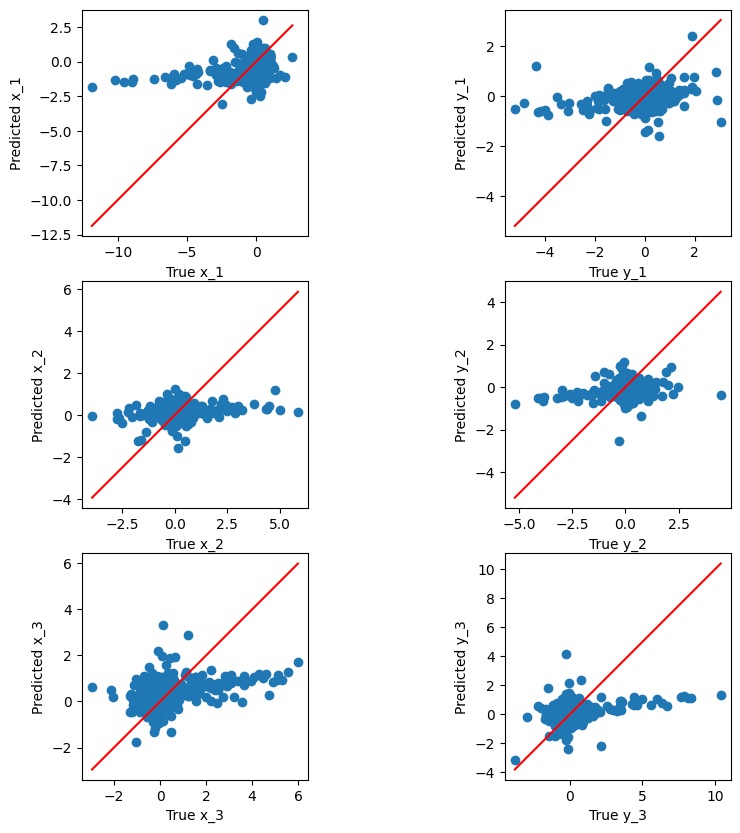

In [99]:
columns_to_drop = ['v_x_1', 'v_y_2']
X_train_reduced = X_train_samp.drop(columns=columns_to_drop)
X_val_reduced = X_val.drop(columns=columns_to_drop)

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)
rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE : {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced")

### Evaluation of Variable Reduction

In [230]:
polynomial_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', Ridge(alpha=1.0))
])

In [231]:
columns_to_drop = ['v_y_3']
X_train_reduced = X_train_samp.drop(columns=columns_to_drop)
X_val_reduced = X_val.drop(columns=columns_to_drop)

polynomial_pipeline.fit(X_train_reduced, y_train_samp)

y_val_pred_poli = polynomial_pipeline.predict(X_val_reduced )

rmse_val_poli = np.sqrt(mean_squared_error(y_val, y_val_pred_poli))
print('RMSE polynomial ',rmse_val_poli)

RMSE polynomial  1.2227150887856368


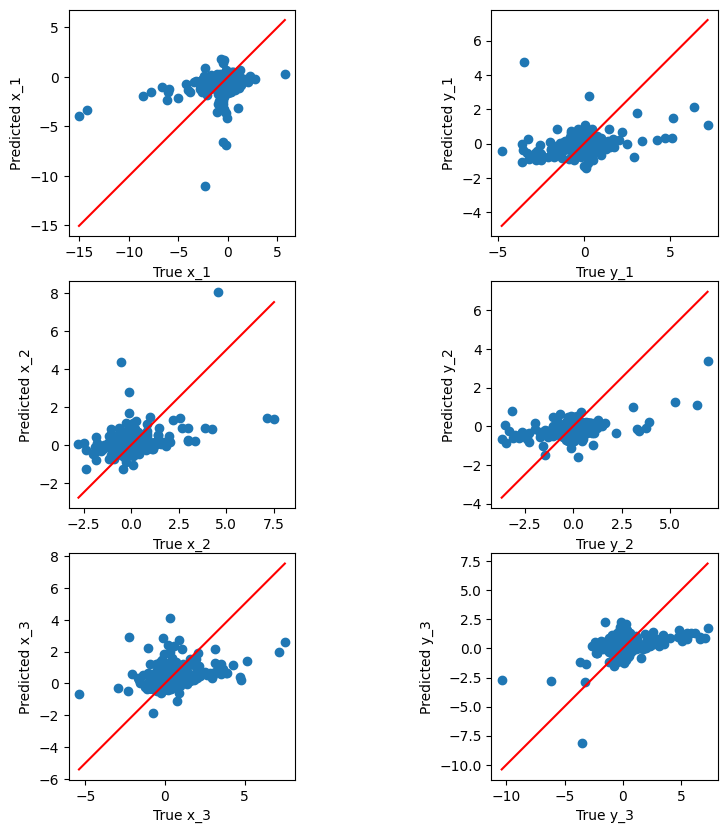

In [116]:
plot_y_yhat(y_val,y_val_pred_poli, plot_title = "plot")

###Adding Variables

Relative velocities

In [121]:
X_train_samp_copy = X_train_samp.copy()
X_val_copy = X_val.copy()

X_train_samp_copy['v_diff_12_x'] = X_train_samp_copy['v_x_2'] - X_train_samp_copy['v_x_1']
X_train_samp_copy['v_diff_12_y'] = X_train_samp_copy['v_y_2'] - X_train_samp_copy['v_y_1']
X_train_samp_copy['v_diff_13_x'] = X_train_samp_copy['v_x_3'] - X_train_samp_copy['v_x_1']
X_train_samp_copy['v_diff_13_y'] = X_train_samp_copy['v_y_3'] - X_train_samp_copy['v_y_1']

X_val_copy['v_diff_12_x'] = X_val_copy['v_x_2'] - X_val_copy['v_x_1']
X_val_copy['v_diff_12_y'] = X_val_copy['v_y_2'] - X_val_copy['v_y_1']
X_val_copy['v_diff_13_x'] = X_val_copy['v_x_3'] - X_val_copy['v_x_1']
X_val_copy['v_diff_13_y'] = X_val_copy['v_y_3'] - X_val_copy['v_y_1']



RMSE: 1.2360


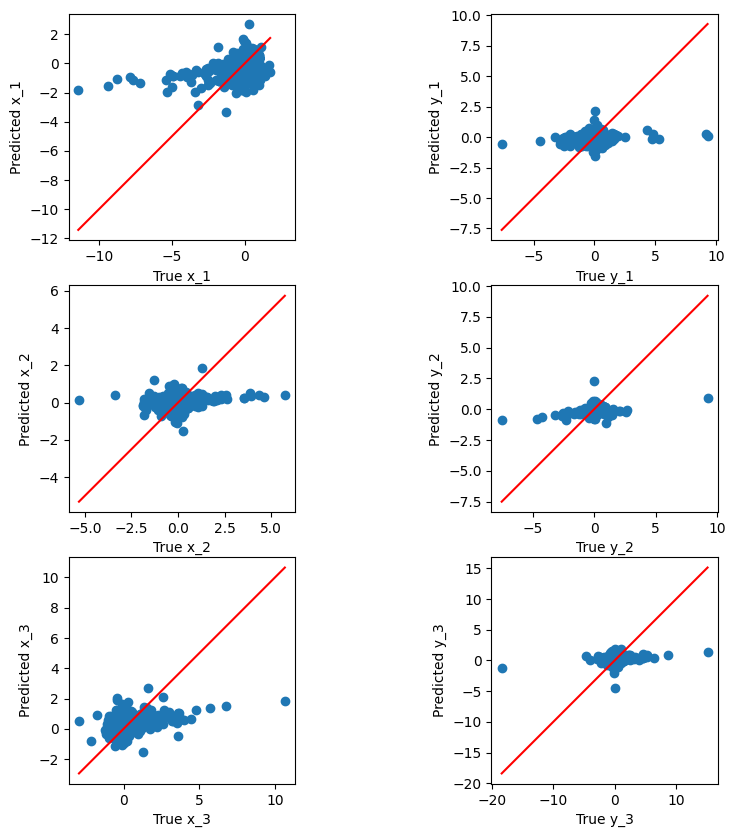

In [123]:
X_train_reduced = X_train_samp_copy
X_val_reduced = X_val_copy

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)

rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE: {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced_with_new_features")

Velocity magnitudes

In [128]:

X_train_samp_copy = X_train_samp.copy()
X_val_copy = X_val.copy()

X_train_samp_copy['v_magnitude_1'] = np.sqrt(X_train_samp_copy['v_x_1']**2 + X_train_samp_copy['v_y_1']**2)
X_train_samp_copy['v_magnitude_2'] = np.sqrt(X_train_samp_copy['v_x_2']**2 + X_train_samp_copy['v_y_2']**2)
X_train_samp_copy['v_magnitude_3'] = np.sqrt(X_train_samp_copy['v_x_3']**2 + X_train_samp_copy['v_y_3']**2)

X_val_copy['v_magnitude_1'] = np.sqrt(X_val_copy['v_x_1']**2 + X_val_copy['v_y_1']**2)
X_val_copy['v_magnitude_2'] = np.sqrt(X_val_copy['v_x_2']**2 + X_val_copy['v_y_2']**2)
X_val_copy['v_magnitude_3'] = np.sqrt(X_val_copy['v_x_3']**2 + X_val_copy['v_y_3']**2)


RMSE: 1.2313


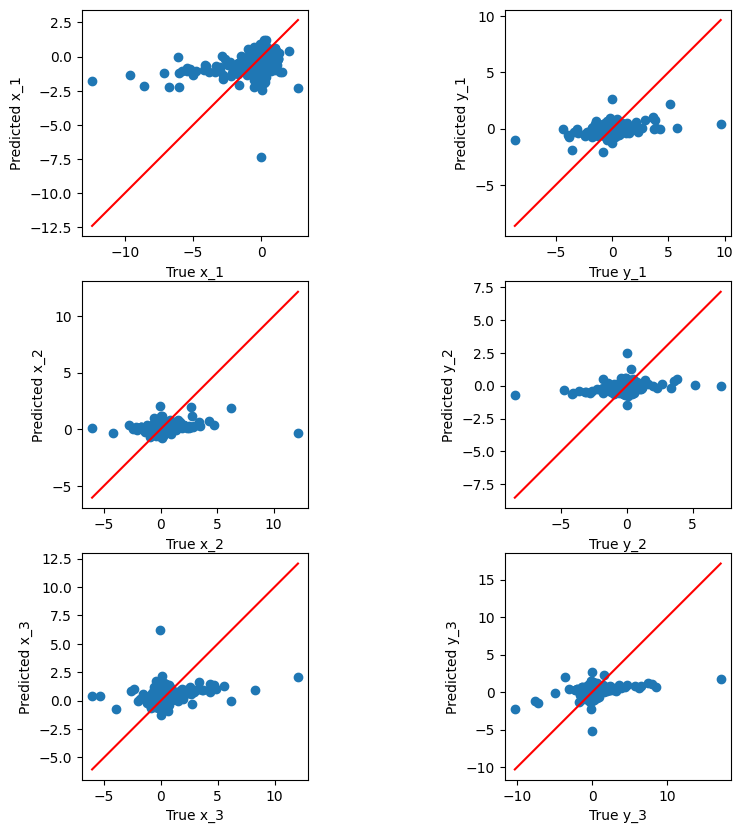

In [129]:
X_train_reduced = X_train_samp_copy
X_val_reduced = X_val_copy

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)

rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE: {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced_with_new_features")

Approximated Distances

In [130]:
X_train_samp_copy = X_train_samp.copy()
X_val_copy = X_val.copy()

X_train_samp_copy['approx_distance_12'] = np.sqrt((X_train_samp_copy['v_x_2'] - X_train_samp_copy['v_x_1'])**2 + (X_train_samp_copy['v_y_2'] - X_train_samp_copy['v_y_1'])**2)
X_train_samp_copy['approx_distance_13'] = np.sqrt((X_train_samp_copy['v_x_3'] - X_train_samp_copy['v_x_1'])**2 + (X_train_samp_copy['v_y_3'] - X_train_samp_copy['v_y_1'])**2)
X_train_samp_copy['approx_distance_23'] = np.sqrt((X_train_samp_copy['v_x_3'] - X_train_samp_copy['v_x_2'])**2 + (X_train_samp_copy['v_y_3'] - X_train_samp_copy['v_y_2'])**2)

X_val_copy['approx_distance_12'] = np.sqrt((X_val_copy['v_x_2'] - X_val_copy['v_x_1'])**2 + (X_val_copy['v_y_2'] - X_val_copy['v_y_1'])**2)
X_val_copy['approx_distance_13'] = np.sqrt((X_val_copy['v_x_3'] - X_val_copy['v_x_1'])**2 + (X_val_copy['v_y_3'] - X_val_copy['v_y_1'])**2)
X_val_copy['approx_distance_23'] = np.sqrt((X_val_copy['v_x_3'] - X_val_copy['v_x_2'])**2 + (X_val_copy['v_y_3'] - X_val_copy['v_y_2'])**2)

RMSE: 1.3456


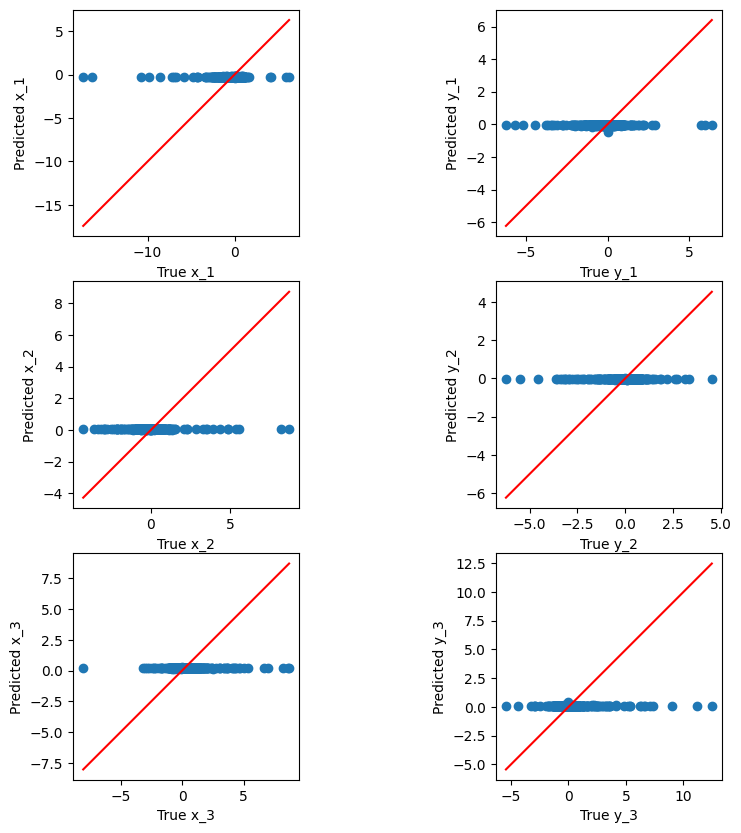

In [232]:
X_train_reduced = X_train_samp_copy
X_val_reduced = X_val_copy

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)

rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE: {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced_with_new_features")

Kinetic energy approximation using velocities

In [132]:
X_train_samp_copy = X_train_samp.copy()
X_val_copy = X_val.copy()

X_train_samp_copy['KE_1'] = 0.5 * (X_train_samp_copy['v_x_1']**2 + X_train_samp_copy['v_y_1']**2)
X_train_samp_copy['KE_2'] = 0.5 * (X_train_samp_copy['v_x_2']**2 + X_train_samp_copy['v_y_2']**2)
X_train_samp_copy['KE_3'] = 0.5 * (X_train_samp_copy['v_x_3']**2 + X_train_samp_copy['v_y_3']**2)

X_val_copy['KE_1'] = 0.5 * (X_val_copy['v_x_1']**2 + X_val_copy['v_y_1']**2)
X_val_copy['KE_2'] = 0.5 * (X_val_copy['v_x_2']**2 + X_val_copy['v_y_2']**2)
X_val_copy['KE_3'] = 0.5 * (X_val_copy['v_x_3']**2 + X_val_copy['v_y_3']**2)

RMSE: 1.2328


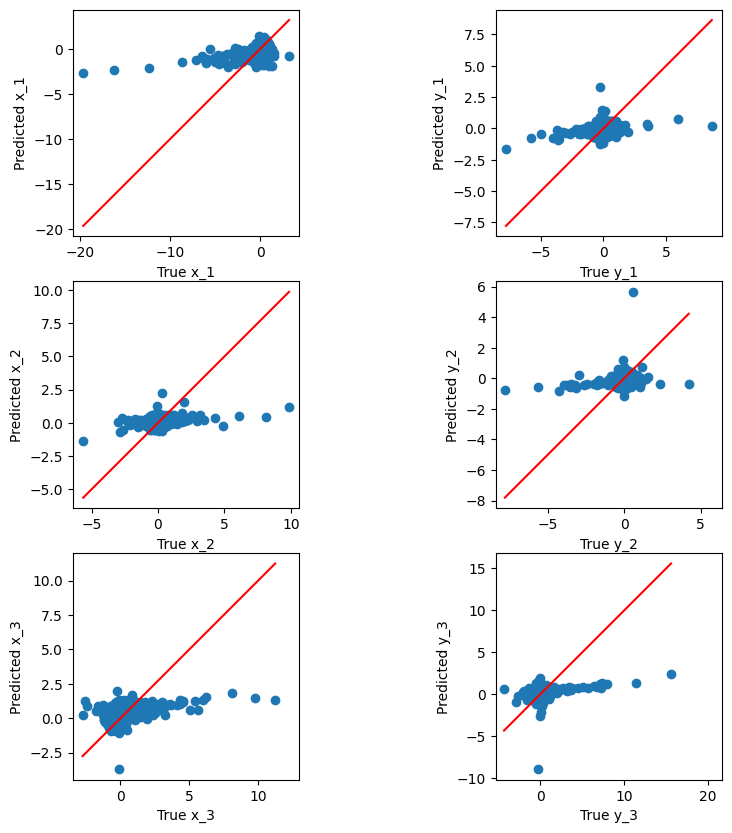

In [133]:
X_train_reduced = X_train_samp_copy
X_val_reduced = X_val_copy

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)

rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE: {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced_with_new_features")

Lets try adding aproximated distances and kinetics energy




In [142]:
X_train_samp_copy = X_train_samp.copy()
X_val_copy = X_val.copy()

X_train_samp_copy['approx_distance_12'] = np.sqrt((X_train_samp_copy['v_x_2'] - X_train_samp_copy['v_x_1'])**2 + (X_train_samp_copy['v_y_2'] - X_train_samp_copy['v_y_1'])**2)
X_train_samp_copy['approx_distance_13'] = np.sqrt((X_train_samp_copy['v_x_3'] - X_train_samp_copy['v_x_1'])**2 + (X_train_samp_copy['v_y_3'] - X_train_samp_copy['v_y_1'])**2)
X_train_samp_copy['approx_distance_23'] = np.sqrt((X_train_samp_copy['v_x_3'] - X_train_samp_copy['v_x_2'])**2 + (X_train_samp_copy['v_y_3'] - X_train_samp_copy['v_y_2'])**2)

X_val_copy['approx_distance_12'] = np.sqrt((X_val_copy['v_x_2'] - X_val_copy['v_x_1'])**2 + (X_val_copy['v_y_2'] - X_val_copy['v_y_1'])**2)
X_val_copy['approx_distance_13'] = np.sqrt((X_val_copy['v_x_3'] - X_val_copy['v_x_1'])**2 + (X_val_copy['v_y_3'] - X_val_copy['v_y_1'])**2)
X_val_copy['approx_distance_23'] = np.sqrt((X_val_copy['v_x_3'] - X_val_copy['v_x_2'])**2 + (X_val_copy['v_y_3'] - X_val_copy['v_y_2'])**2)


X_train_samp_copy['KE_1'] = 0.5 * (X_train_samp_copy['v_x_1']**2 + X_train_samp_copy['v_y_1']**2)
X_train_samp_copy['KE_2'] = 0.5 * (X_train_samp_copy['v_x_2']**2 + X_train_samp_copy['v_y_2']**2)
X_train_samp_copy['KE_3'] = 0.5 * (X_train_samp_copy['v_x_3']**2 + X_train_samp_copy['v_y_3']**2)

X_val_copy['KE_1'] = 0.5 * (X_val_copy['v_x_1']**2 + X_val_copy['v_y_1']**2)
X_val_copy['KE_2'] = 0.5 * (X_val_copy['v_x_2']**2 + X_val_copy['v_y_2']**2)
X_val_copy['KE_3'] = 0.5 * (X_val_copy['v_x_3']**2 + X_val_copy['v_y_3']**2)

RMSE: 1.2312


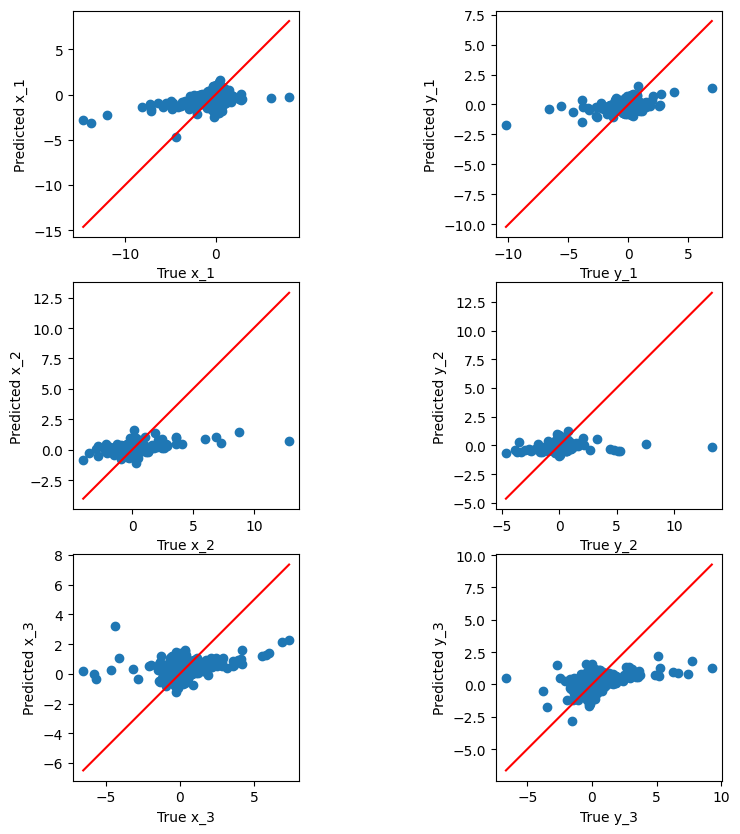

In [143]:
X_train_reduced = X_train_samp_copy
X_val_reduced = X_val_copy

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)

rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE: {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced_with_new_features")

Lets try adding three

In [144]:
X_train_samp_copy = X_train_samp.copy()
X_val_copy = X_val.copy()

X_train_samp_copy['approx_distance_12'] = np.sqrt((X_train_samp_copy['v_x_2'] - X_train_samp_copy['v_x_1'])**2 + (X_train_samp_copy['v_y_2'] - X_train_samp_copy['v_y_1'])**2)
X_train_samp_copy['approx_distance_13'] = np.sqrt((X_train_samp_copy['v_x_3'] - X_train_samp_copy['v_x_1'])**2 + (X_train_samp_copy['v_y_3'] - X_train_samp_copy['v_y_1'])**2)
X_train_samp_copy['approx_distance_23'] = np.sqrt((X_train_samp_copy['v_x_3'] - X_train_samp_copy['v_x_2'])**2 + (X_train_samp_copy['v_y_3'] - X_train_samp_copy['v_y_2'])**2)

X_val_copy['approx_distance_12'] = np.sqrt((X_val_copy['v_x_2'] - X_val_copy['v_x_1'])**2 + (X_val_copy['v_y_2'] - X_val_copy['v_y_1'])**2)
X_val_copy['approx_distance_13'] = np.sqrt((X_val_copy['v_x_3'] - X_val_copy['v_x_1'])**2 + (X_val_copy['v_y_3'] - X_val_copy['v_y_1'])**2)
X_val_copy['approx_distance_23'] = np.sqrt((X_val_copy['v_x_3'] - X_val_copy['v_x_2'])**2 + (X_val_copy['v_y_3'] - X_val_copy['v_y_2'])**2)


X_train_samp_copy['KE_1'] = 0.5 * (X_train_samp_copy['v_x_1']**2 + X_train_samp_copy['v_y_1']**2)
X_train_samp_copy['KE_2'] = 0.5 * (X_train_samp_copy['v_x_2']**2 + X_train_samp_copy['v_y_2']**2)
X_train_samp_copy['KE_3'] = 0.5 * (X_train_samp_copy['v_x_3']**2 + X_train_samp_copy['v_y_3']**2)

X_val_copy['KE_1'] = 0.5 * (X_val_copy['v_x_1']**2 + X_val_copy['v_y_1']**2)
X_val_copy['KE_2'] = 0.5 * (X_val_copy['v_x_2']**2 + X_val_copy['v_y_2']**2)
X_val_copy['KE_3'] = 0.5 * (X_val_copy['v_x_3']**2 + X_val_copy['v_y_3']**2)


X_train_samp_copy['v_magnitude_1'] = np.sqrt(X_train_samp_copy['v_x_1']**2 + X_train_samp_copy['v_y_1']**2)
X_train_samp_copy['v_magnitude_2'] = np.sqrt(X_train_samp_copy['v_x_2']**2 + X_train_samp_copy['v_y_2']**2)
X_train_samp_copy['v_magnitude_3'] = np.sqrt(X_train_samp_copy['v_x_3']**2 + X_train_samp_copy['v_y_3']**2)

X_val_copy['v_magnitude_1'] = np.sqrt(X_val_copy['v_x_1']**2 + X_val_copy['v_y_1']**2)
X_val_copy['v_magnitude_2'] = np.sqrt(X_val_copy['v_x_2']**2 + X_val_copy['v_y_2']**2)
X_val_copy['v_magnitude_3'] = np.sqrt(X_val_copy['v_x_3']**2 + X_val_copy['v_y_3']**2)


RMSE: 1.2265


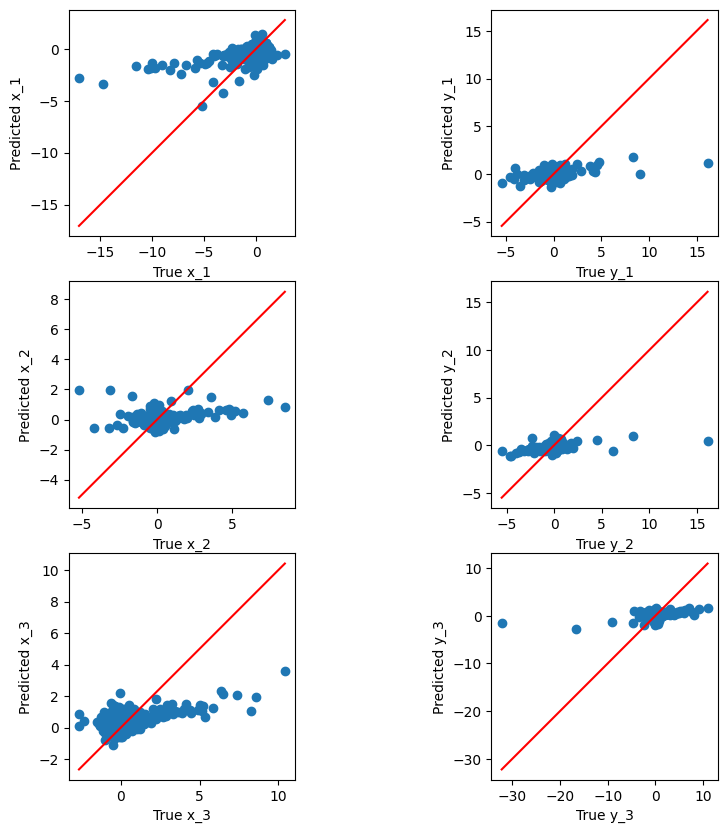

In [145]:
X_train_reduced = X_train_samp_copy
X_val_reduced = X_val_copy

linear_model.fit(X_train_reduced, y_train_samp)

y_val_pred_reduced = linear_model.predict(X_val_reduced)

rmse_reduced = np.sqrt(mean_squared_error(y_val, y_val_pred_reduced))
print(f"RMSE: {rmse_reduced:.4f}")

plot_y_yhat(y_val, y_val_pred_reduced, plot_title="y_yhat_reduced_with_new_features")

### Evaluation of Variable Addition

In [163]:
X_train_samp_copy = X_train_samp.copy()
X_val_copy = X_val.copy()

X_train_samp_copy['approx_distance_12'] = np.sqrt((X_train_samp_copy['v_x_2'] - X_train_samp_copy['v_x_1'])**2 + (X_train_samp_copy['v_y_2'] - X_train_samp_copy['v_y_1'])**2)
X_train_samp_copy['approx_distance_13'] = np.sqrt((X_train_samp_copy['v_x_3'] - X_train_samp_copy['v_x_1'])**2 + (X_train_samp_copy['v_y_3'] - X_train_samp_copy['v_y_1'])**2)
X_train_samp_copy['approx_distance_23'] = np.sqrt((X_train_samp_copy['v_x_3'] - X_train_samp_copy['v_x_2'])**2 + (X_train_samp_copy['v_y_3'] - X_train_samp_copy['v_y_2'])**2)

X_val_copy['approx_distance_12'] = np.sqrt((X_val_copy['v_x_2'] - X_val_copy['v_x_1'])**2 + (X_val_copy['v_y_2'] - X_val_copy['v_y_1'])**2)
X_val_copy['approx_distance_13'] = np.sqrt((X_val_copy['v_x_3'] - X_val_copy['v_x_1'])**2 + (X_val_copy['v_y_3'] - X_val_copy['v_y_1'])**2)
X_val_copy['approx_distance_23'] = np.sqrt((X_val_copy['v_x_3'] - X_val_copy['v_x_2'])**2 + (X_val_copy['v_y_3'] - X_val_copy['v_y_2'])**2)


X_train_samp_copy['KE_1'] = 0.5 * (X_train_samp_copy['v_x_1']**2 + X_train_samp_copy['v_y_1']**2)
X_train_samp_copy['KE_2'] = 0.5 * (X_train_samp_copy['v_x_2']**2 + X_train_samp_copy['v_y_2']**2)
X_train_samp_copy['KE_3'] = 0.5 * (X_train_samp_copy['v_x_3']**2 + X_train_samp_copy['v_y_3']**2)

X_val_copy['KE_1'] = 0.5 * (X_val_copy['v_x_1']**2 + X_val_copy['v_y_1']**2)
X_val_copy['KE_2'] = 0.5 * (X_val_copy['v_x_2']**2 + X_val_copy['v_y_2']**2)
X_val_copy['KE_3'] = 0.5 * (X_val_copy['v_x_3']**2 + X_val_copy['v_y_3']**2)


X_train_samp_copy['v_magnitude_1'] = np.sqrt(X_train_samp_copy['v_x_1']**2 + X_train_samp_copy['v_y_1']**2)
X_train_samp_copy['v_magnitude_2'] = np.sqrt(X_train_samp_copy['v_x_2']**2 + X_train_samp_copy['v_y_2']**2)
X_train_samp_copy['v_magnitude_3'] = np.sqrt(X_train_samp_copy['v_x_3']**2 + X_train_samp_copy['v_y_3']**2)

X_val_copy['v_magnitude_1'] = np.sqrt(X_val_copy['v_x_1']**2 + X_val_copy['v_y_1']**2)
X_val_copy['v_magnitude_2'] = np.sqrt(X_val_copy['v_x_2']**2 + X_val_copy['v_y_2']**2)
X_val_copy['v_magnitude_3'] = np.sqrt(X_val_copy['v_x_3']**2 + X_val_copy['v_y_3']**2)

RMSE: 1.1408


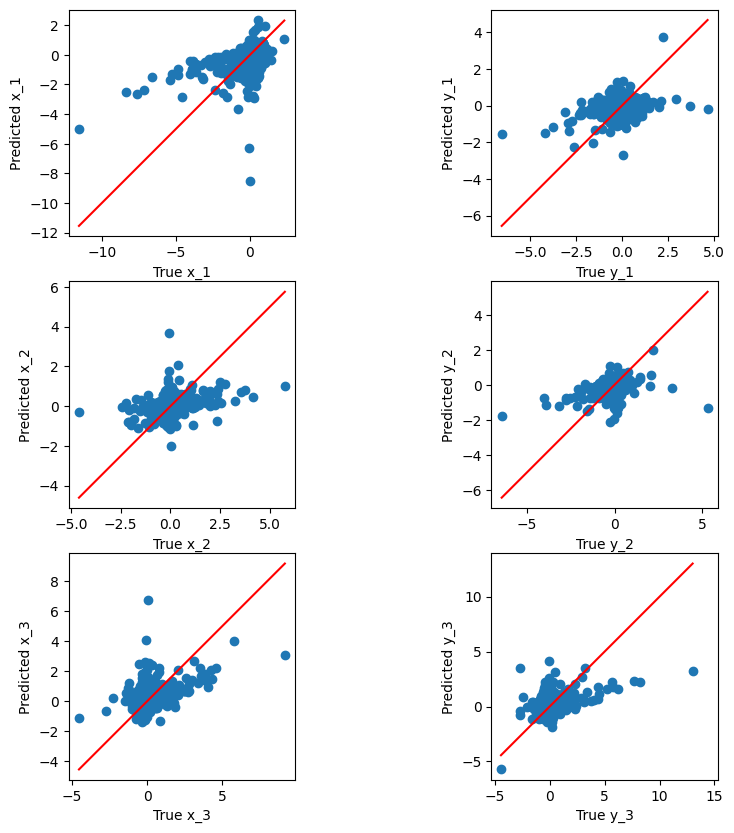

In [164]:
X_train_add= X_train_samp_copy
X_val_add = X_val_copy

polynomial_pipeline.fit(X_train_add, y_train_samp)

y_val_pred_add= polynomial_pipeline.predict(X_val_add)

rmse_add = np.sqrt(mean_squared_error(y_val, y_val_pred_add))
print(f"RMSE: {rmse_add:.4f}")

plot_y_yhat(y_val, y_val_pred_add, plot_title="y_yhat_add_with_new_features")

# Task 4

In [234]:
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15)):
    rmse_train = {}
    rmse_val = {}

    for n_neighbors in k:
        knn = KNeighborsRegressor(n_neighbors=n_neighbors)

        knn.fit(X_train, y_train)

        y_train_pred = knn.predict(X_train)
        y_val_pred = knn.predict(X_val)

        rmse_train[n_neighbors] = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_val[n_neighbors] = np.sqrt(mean_squared_error(y_val, y_val_pred))

        print(f"k = {n_neighbors}: RMSE train = {rmse_train[n_neighbors]:.4f}, RMSE Validación = {rmse_val[n_neighbors]:.4f}")

    return rmse_train, rmse_val

In [235]:
rmse_train, rmse_val = validate_knn_regression(X_train_samp, y_train_samp, X_val, y_val)

best_k = min(rmse_val, key=rmse_val.get)
print(f"Best {best_k}  RMSE {rmse_val[best_k]:.4f}")

k = 1: RMSE train = 0.0000, RMSE Validación = 0.0451
k = 2: RMSE train = 0.0215, RMSE Validación = 0.0357
k = 3: RMSE train = 0.0241, RMSE Validación = 0.0399
k = 4: RMSE train = 0.0297, RMSE Validación = 0.0418
k = 5: RMSE train = 0.0333, RMSE Validación = 0.0438
k = 6: RMSE train = 0.0364, RMSE Validación = 0.0460
k = 7: RMSE train = 0.0399, RMSE Validación = 0.0526
k = 8: RMSE train = 0.0464, RMSE Validación = 0.0642
k = 9: RMSE train = 0.0554, RMSE Validación = 0.0763
k = 10: RMSE train = 0.0687, RMSE Validación = 0.0899
k = 11: RMSE train = 0.0829, RMSE Validación = 0.1063
k = 12: RMSE train = 0.0975, RMSE Validación = 0.1222
k = 13: RMSE train = 0.1122, RMSE Validación = 0.1372
k = 14: RMSE train = 0.1264, RMSE Validación = 0.1520
Best 2  RMSE 0.0357


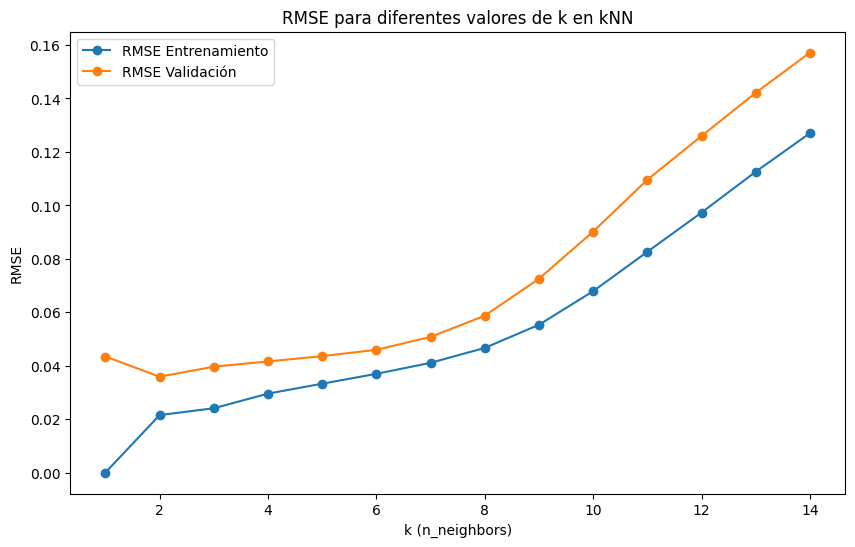

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(list(rmse_train.keys()), list(rmse_train.values()), label='RMSE Entrenamiento', marker='o')
plt.plot(list(rmse_val.keys()), list(rmse_val.values()), label='RMSE Validación', marker='o')
plt.xlabel('k (n_neighbors)')
plt.ylabel('RMSE')
plt.title('RMSE para diferentes valores de k en kNN')
plt.legend()
plt.show()


In [160]:
best_k = min(rmse_val, key=rmse_val.get)
print(f"El mejor valor de k es: {best_k}")

El mejor valor de k es: 2


RMSE: 0.0359


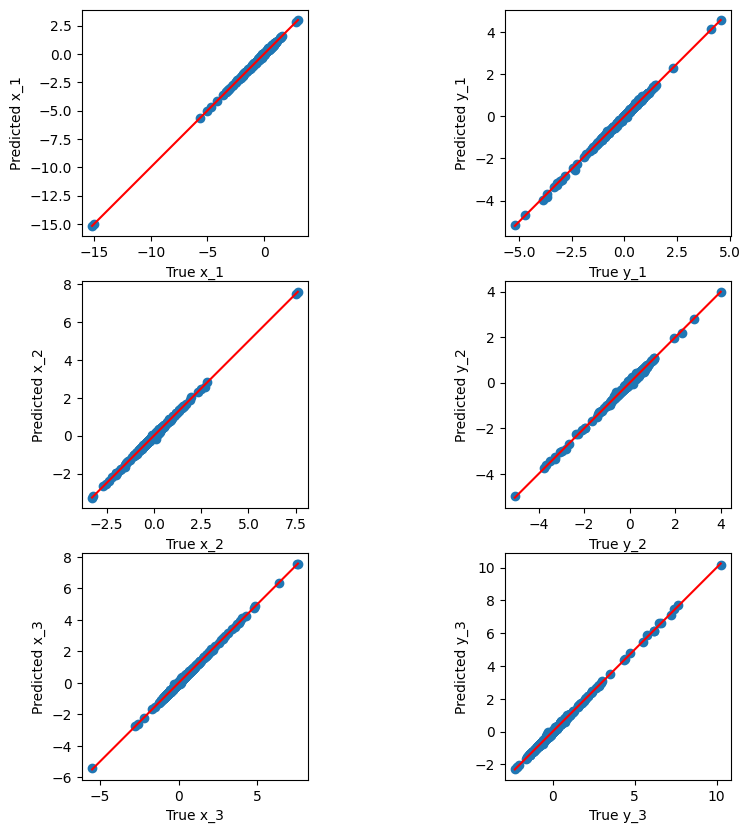

In [162]:
knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train_samp, y_train_samp)
y_val_pred_best = knn_best.predict(X_val)
rmse_best = np.sqrt(mean_squared_error(y_val, y_val_pred_best))
print(f"RMSE: {rmse_best :.4f}")

plot_y_yhat(y_val, y_val_pred_best, plot_title="y_yhat_reduced_with_new_features")

Best model feature engeniring, three added variables

RMSE addin features: 1.1408


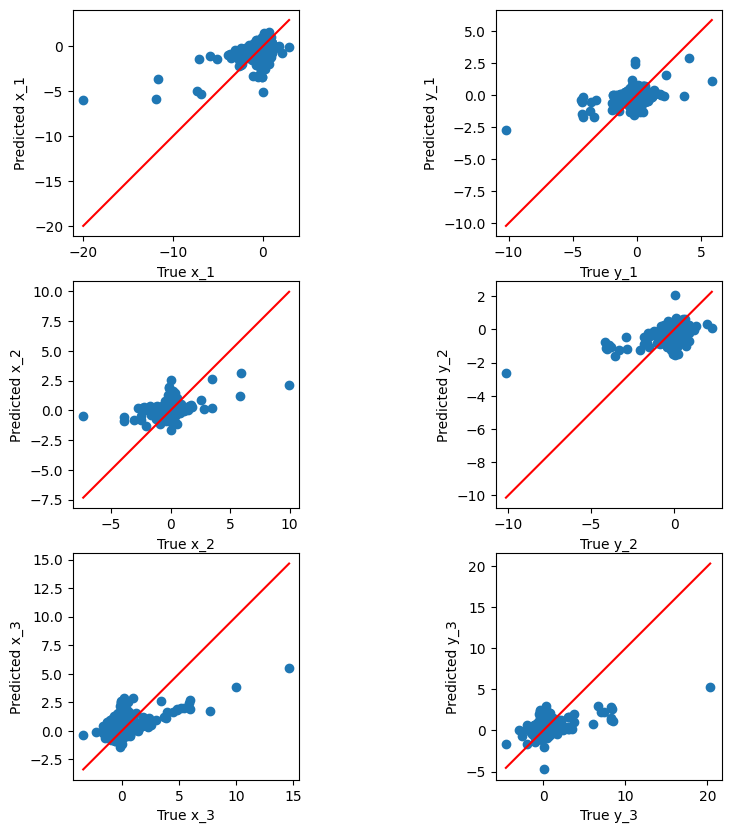

In [166]:
print(f"RMSE addin features: {rmse_add:.4f}")

plot_y_yhat(y_val, y_val_pred_add, plot_title="y_yhat_add_with_new_features")

Best model task 2

1.1963013933513515


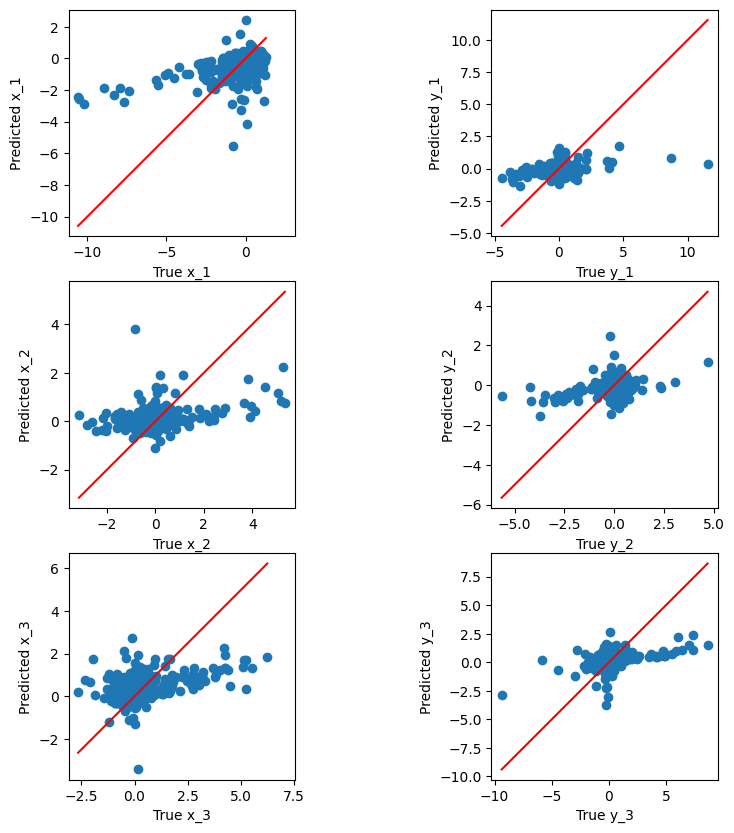

In [169]:
rmse_val_poli = np.sqrt(mean_squared_error(y_val, y_val_pred_poli))
print(rmse_val_poli)
plot_y_yhat(y_val,y_val_pred_poli, plot_title = "plot")

# Final model evaluation

Lets try our best model with the test

RMSE: 1.4527


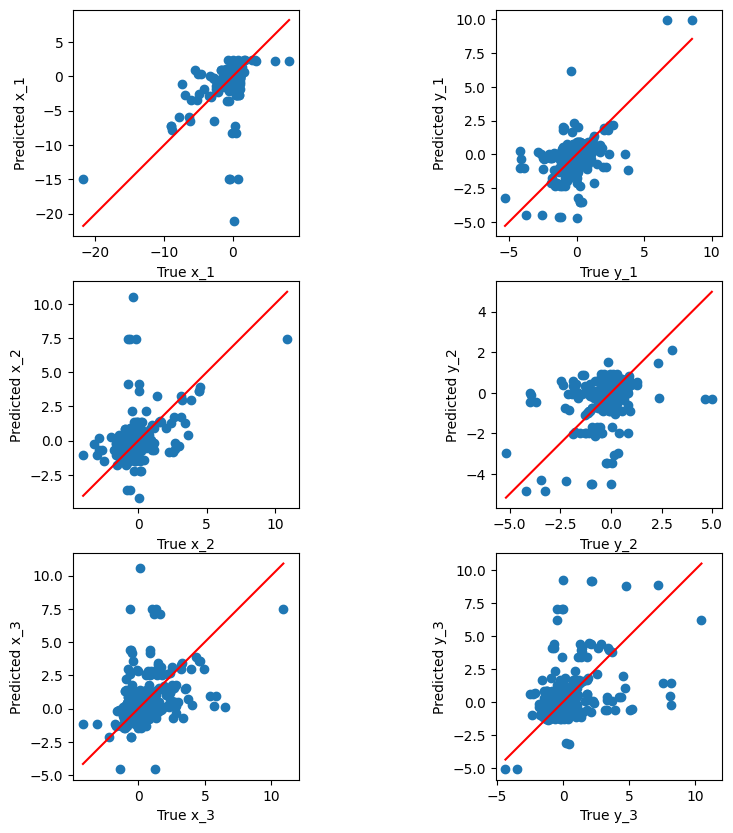

In [171]:
knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train_samp, y_train_samp)
y_val_pred_best = knn_best.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_val_pred_best))
print(f"RMSE: {rmse_best :.4f}")

plot_y_yhat(y_test, y_val_pred_best, plot_title="y_yhat_reduced_with_new_features")